In [4]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, PReLU, ThresholdedReLU,  BatchNormalization, GlobalAveragePooling2D, LSTM, TimeDistributed, MaxPooling2D, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.activations import swish
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [5]:
combined_dir = r'D:\PKG - C-NMC 2019\C-NMC_combined_data'
all_dir = os.path.join(combined_dir, 'all')
hem_dir = os.path.join(combined_dir, 'hem')

In [6]:
img_width, img_height = 224, 224  
batch_size = 16
epochs = 40

In [7]:
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.05)  # 5% for validation

def create_data_generators(combined_dir, img_width, img_height, batch_size):
    train_generator = datagen.flow_from_directory(
        combined_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale',
        subset='training'  # 95% for training
    )
    test_generator = datagen.flow_from_directory(
        combined_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale',
        subset='validation'  # 5% for validation
    )
    return train_generator, test_generator

train_generator, test_generator = create_data_generators(combined_dir, img_width, img_height, batch_size)


Found 10129 images belonging to 2 classes.
Found 532 images belonging to 2 classes.


In [5]:
def create_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='softsign', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='softsign', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='softsign', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='softsign', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='softsign', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='softsign'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [8]:

# Callbacks for dynamic learning rate and early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

#reduce_lr_on_plateau = ReduceLROnPlateau(
 #   monitor='val_loss', 
  #  factor=0.45, 
   # patience=4, 
    #min_lr=1e-7,
    #verbose=1
#)

In [9]:
import tensorflow as tf

class ReduceLROnPlateauCombined(tf.keras.callbacks.Callback):
    def __init__(self, monitor_loss='val_loss', monitor_accuracy='val_accuracy', 
                factor=0.45, patience=2, min_lr=1e-9, verbose=1):
        super().__init__()
        self.monitor_loss = monitor_loss
        self.monitor_accuracy = monitor_accuracy
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait_loss = 0
        self.wait_accuracy = 0
        self.best_loss = float('inf')
        self.best_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor_loss)
        current_accuracy = logs.get(self.monitor_accuracy)
        
        if current_loss is None or current_accuracy is None:
            return
        
        # Check loss metric
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait_loss = 0
        else:
            self.wait_loss += 1

        # Check accuracy metric
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait_accuracy = 0
        else:
            self.wait_accuracy += 1

        # Apply learning rate reduction based on patience
        if self.wait_loss >= self.patience and self.wait_accuracy >= self.patience:
            old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            new_lr = max(old_lr * self.factor, self.min_lr)
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
            if self.verbose > 0:
                print(f'\nEpoch {epoch+1}: Reducing learning rate to {new_lr}.')
            self.wait_loss = 0
            self.wait_accuracy = 0

# Example usage in model training
reduce_lr_on_plateau = ReduceLROnPlateauCombined()

# model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[reduce_lr_on_plateau])


In [30]:

# Train the model
print("Training with combined dataset")
model_softsign = create_model()
history = model_softsign.fit(
    train_generator,
    steps_per_epoch=450,
    validation_data=test_generator,
    validation_steps=25,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)


Training with combined dataset


KeyboardInterrupt: 

In [ ]:

# Save the model
model_softsign.save('model_softsign.h5')
print("Model saved as model_softsign.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = model_softsign.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as model_softsign.h5
Evaluating the model on the test data
33/33 [==============================] - 1s 37ms/step - loss: 0.3814 - accuracy: 0.8314
Test Loss: 0.3814
Test Accuracy: 0.8314


: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming you have your history object and test loss and accuracy
# Test Loss and Accuracy
test_loss = 0.3513
test_accuracy = 0.8826

# Extracting data from history
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Determine the number of completed epochs
epochs = len(train_accuracy)
epoch_range = np.arange(1, epochs + 1)

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


In [10]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Add, Activation, BatchNormalization, AveragePooling2D, Input, Dropout
from keras.models import Model
from keras.optimizers import Adam

def resnet_block(x, filters, kernel_size, stride, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x_input = x  # Store the input tensor to add later

    x = Conv2D(filters, kernel_size, padding='same', strides=stride, name=conv_name_base + '2a')(x)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)

    # Shortcut connection to adjust dimensions
    if stride != 1 or x_input.shape[-1] != filters:
        x_input = Conv2D(filters, (1, 1), padding='same', strides=stride, name=conv_name_base + '1')(x_input)
        x_input = BatchNormalization(name=bn_name_base + '1')(x_input)

    x = Add()([x, x_input])
    x = Activation('relu')(x)

    return x

def resnet50_binary(img_width, img_height):
    x_input = Input(shape=(img_width, img_height, 1))

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(x_input)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = resnet_block(x, 64, 3, 1, stage=2, block='a')
    x = resnet_block(x, 64, 3, 1, stage=2, block='b')
    x = resnet_block(x, 64, 3, 1, stage=2, block='c')

    x = resnet_block(x, 128, 3, 2, stage=3, block='a')
    x = resnet_block(x, 128, 3, 1, stage=3, block='b')
    x = resnet_block(x, 128, 3, 1, stage=3, block='c')
    x = resnet_block(x, 128, 3, 1, stage=3, block='d')

    x = resnet_block(x, 256, 3, 2, stage=4, block='a')
    x = resnet_block(x, 256, 3, 1, stage=4, block='b')
    x = resnet_block(x, 256, 3, 1, stage=4, block='c')
    x = resnet_block(x, 256, 3, 1, stage=4, block='d')
    x = resnet_block(x, 256, 3, 1, stage=4, block='e')
    x = resnet_block(x, 256, 3, 1, stage=4, block='f')

    x = resnet_block(x, 512, 3, 2, stage=5, block='a')
    x = resnet_block(x, 512, 3, 1, stage=5, block='b')
    x = resnet_block(x, 512, 3, 1, stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid', name='fc_binary')(x)

    model = Model(inputs=x_input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])
    return model



img_width, img_height = 224, 224
model_res = resnet50_binary(img_width, img_height)


In [11]:

# Train the model
print("Training with combined dataset")
model_res = resnet50_binary(img_width, img_height)
history = model_res.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=25,
    epochs=40,
    callbacks=[ reduce_lr_on_plateau]
)


Training with combined dataset
Epoch 1/40
633/633 [==============================] - 2259s 4s/step - loss: 0.4828 - accuracy: 0.7898 - val_loss: 0.5014 - val_accuracy: 0.7900
Epoch 2/40
633/633 [==============================] - 2162s 3s/step - loss: 0.4302 - accuracy: 0.8169 - val_loss: 0.4746 - val_accuracy: 0.7700
Epoch 3/40
633/633 [==============================] - 2212s 3s/step - loss: 0.3917 - accuracy: 0.8336 - val_loss: 0.5225 - val_accuracy: 0.7500
Epoch 4/40
633/633 [==============================] - 2169s 3s/step - loss: 0.3630 - accuracy: 0.8484 - val_loss: 0.4424 - val_accuracy: 0.8250
Epoch 5/40
633/633 [==============================] - 2156s 3s/step - loss: 0.3246 - accuracy: 0.8698 - val_loss: 0.9717 - val_accuracy: 0.5375
Epoch 6/40
633/633 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.8873
Epoch 6: Reducing learning rate to 2.249999943160219e-05.
633/633 [==============================] - 2196s 3s/step - loss: 0.2806 - accuracy: 0.8873 - va

KeyboardInterrupt: 

In [12]:

# Save the model
model_res.save('model_res.h5')
print("Model saved as model_res.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = model_res.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as model_res.h5
Evaluating the model on the test data
33/33 [==============================] - 47s 1s/step - loss: 1.1906 - accuracy: 0.8277
Test Loss: 1.1906
Test Accuracy: 0.8277


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming you have your history object and test loss and accuracy
# Test Loss and Accuracy
test_loss = 0.3513
test_accuracy = 0.8826

# Extracting data from history
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Determine the number of completed epochs
epochs = len(train_accuracy)
epoch_range = np.arange(1, epochs + 1)

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


NameError: name 'history' is not defined

The above code works with the softsign activation function.

In [7]:

# CNN model
def create_softplus_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='softplus', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [8]:

# Train the model
print("Training with combined dataset")
model_softplus = create_softplus_model()
history = model_softplus.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/50
633/633 [==============================] - 214s 328ms/step - loss: 0.5624 - accuracy: 0.7282 - val_loss: 0.4432 - val_accuracy: 0.8087
Epoch 2/50
633/633 [==============================] - 120s 189ms/step - loss: 0.4798 - accuracy: 0.7910 - val_loss: 0.4193 - val_accuracy: 0.8125
Epoch 3/50
633/633 [==============================] - 115s 181ms/step - loss: 0.4728 - accuracy: 0.7983 - val_loss: 0.3944 - val_accuracy: 0.8220
Epoch 4/50
633/633 [==============================] - 117s 184ms/step - loss: 0.4702 - accuracy: 0.7986 - val_loss: 0.4040 - val_accuracy: 0.8163
Epoch 5/50
633/633 [==============================] - 113s 178ms/step - loss: 0.4653 - accuracy: 0.7969 - val_loss: 0.3921 - val_accuracy: 0.8277
Epoch 6/50
633/633 [==============================] - 116s 183ms/step - loss: 0.4638 - accuracy: 0.7996 - val_loss: 0.4064 - val_accuracy: 0.8125
Epoch 7/50
633/633 [==============================] - ETA: 0s - loss: 0.4595 - accuracy: 0.80

In [9]:
# Save the model
model_softplus.save('model_softplus.h5')
print("Model saved as model_softplus.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = model_softplus.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as model_softplus.h5
Evaluating the model on the test data
33/33 [==============================] - 1s 36ms/step - loss: 0.3820 - accuracy: 0.8277
Test Loss: 0.3820
Test Accuracy: 0.8277


: 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming you have your history object and test loss and accuracy
# Test Loss and Accuracy

# Extracting data from history
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Determine the number of completed epochs
epochs = len(train_accuracy)
epoch_range = np.arange(1, epochs + 1)

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


The above code is based on softplus activation function

In [ ]:
# CNN model with GELU
def create_gelu_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='gelu', padding='same'),  # Use GELU here
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='gelu', padding='same'),  # Use GELU here
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='gelu'),  # Use GELU here
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Initialize and print summary of the model
gelu_model = create_gelu_model()
gelu_model.summary()


Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_243 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_243 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_141 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_244 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_244 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_245 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
gelu_model = create_gelu_model()
history = gelu_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 137s 214ms/step - loss: 0.4814 - accuracy: 0.7851 - val_loss: 0.4314 - val_accuracy: 0.8011
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.7955
Epoch 2: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 121s 191ms/step - loss: 0.4627 - accuracy: 0.7955 - val_loss: 0.4063 - val_accuracy: 0.8220
Epoch 3/40
633/633 [==============================] - 123s 195ms/step - loss: 0.4509 - accuracy: 0.8025 - val_loss: 0.3899 - val_accuracy: 0.8258
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.4453 - accuracy: 0.8028
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 138s 218ms/step - loss: 0.4453 - accuracy: 0.8028 - val_loss: 0.3898 - val_accuracy: 0.8163
Epoch 5/40
633/633 [==============================] - 147s 233ms/step - loss: 0.4421 - accuracy: 

In [ ]:

# Save the model
gelu_model.save('model_gelu.h5')
print("Model saved as model_gelu.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = gelu_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as model_gelu.h5
Evaluating the model on the test data
33/33 [==============================] - 1s 42ms/step - loss: 0.3900 - accuracy: 0.8087
Test Loss: 0.3900
Test Accuracy: 0.8087


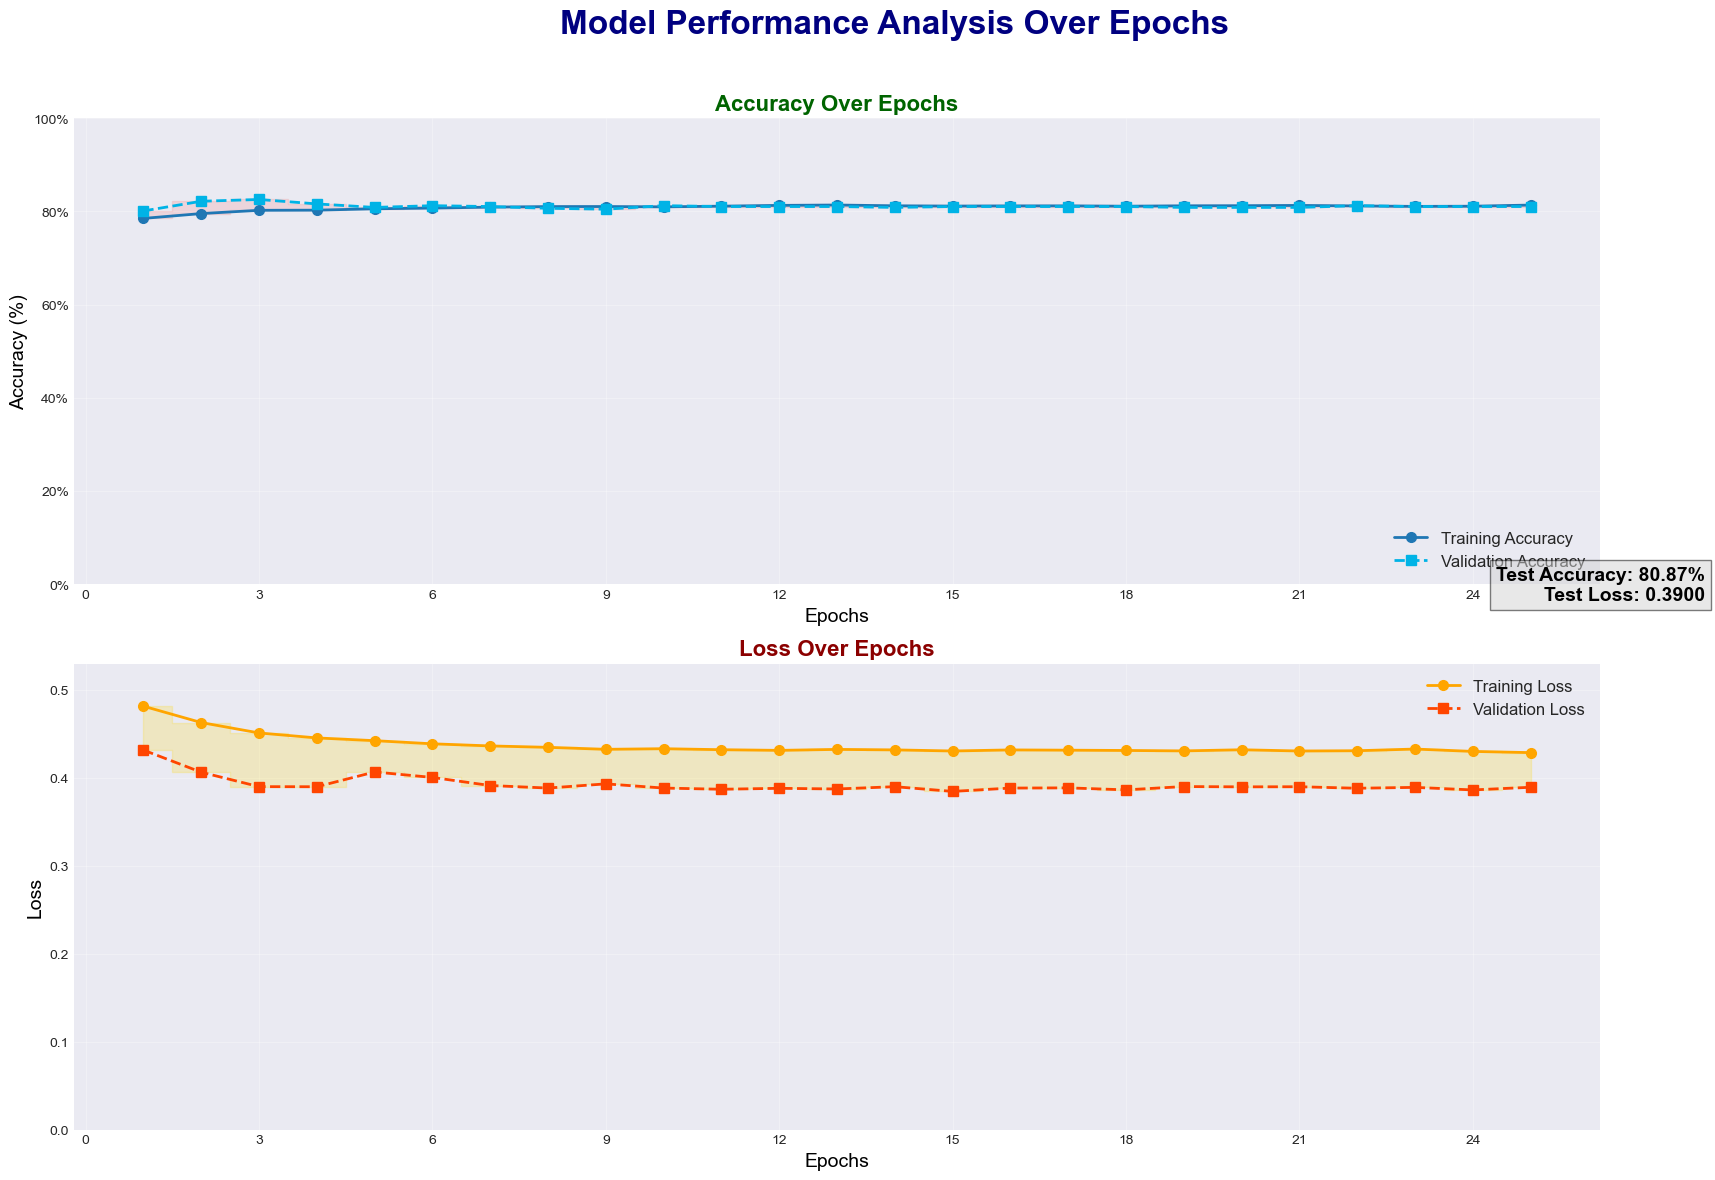

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


The above code is made based on GELU activation functions

In [ ]:
def create_prelu_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
        PReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),  
        PReLU(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),  
        PReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        PReLU(),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='relu'),  
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    
    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
prelu_model = create_prelu_model()
prelu_model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_253 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 p_re_lu_16 (PReLU)          (None, 128, 128, 16)      262144    
                                                                 
 max_pooling2d_253 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_147 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_254 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_254 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                               

In [ ]:

# Train the model
print("Training with combined dataset")
prelu_model = create_prelu_model()
history = prelu_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.7753
Epoch 1: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 146s 228ms/step - loss: 0.5149 - accuracy: 0.7753 - val_loss: 0.4439 - val_accuracy: 0.8352
Epoch 2/40
633/633 [==============================] - 130s 205ms/step - loss: 0.4752 - accuracy: 0.7942 - val_loss: 0.4066 - val_accuracy: 0.8409
Epoch 3/40
633/633 [==============================] - ETA: 0s - loss: 0.4682 - accuracy: 0.7943
Epoch 3: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 126s 198ms/step - loss: 0.4682 - accuracy: 0.7943 - val_loss: 0.3931 - val_accuracy: 0.8371
Epoch 4/40
633/633 [==============================] - 130s 205ms/step - loss: 0.4616 - accuracy: 0.7983 - val_loss: 0.3976 - val_accuracy: 0.8314
Epoch 5/40
633/633 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.7984
E

In [ ]:

# Save the model
prelu_model.save('model_prelu.h5')
print("Model saved as model_prelu.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = prelu_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as model_prelu.h5
Evaluating the model on the test data
33/33 [==============================] - 2s 49ms/step - loss: 0.3971 - accuracy: 0.8295
Test Loss: 0.3971
Test Accuracy: 0.8295


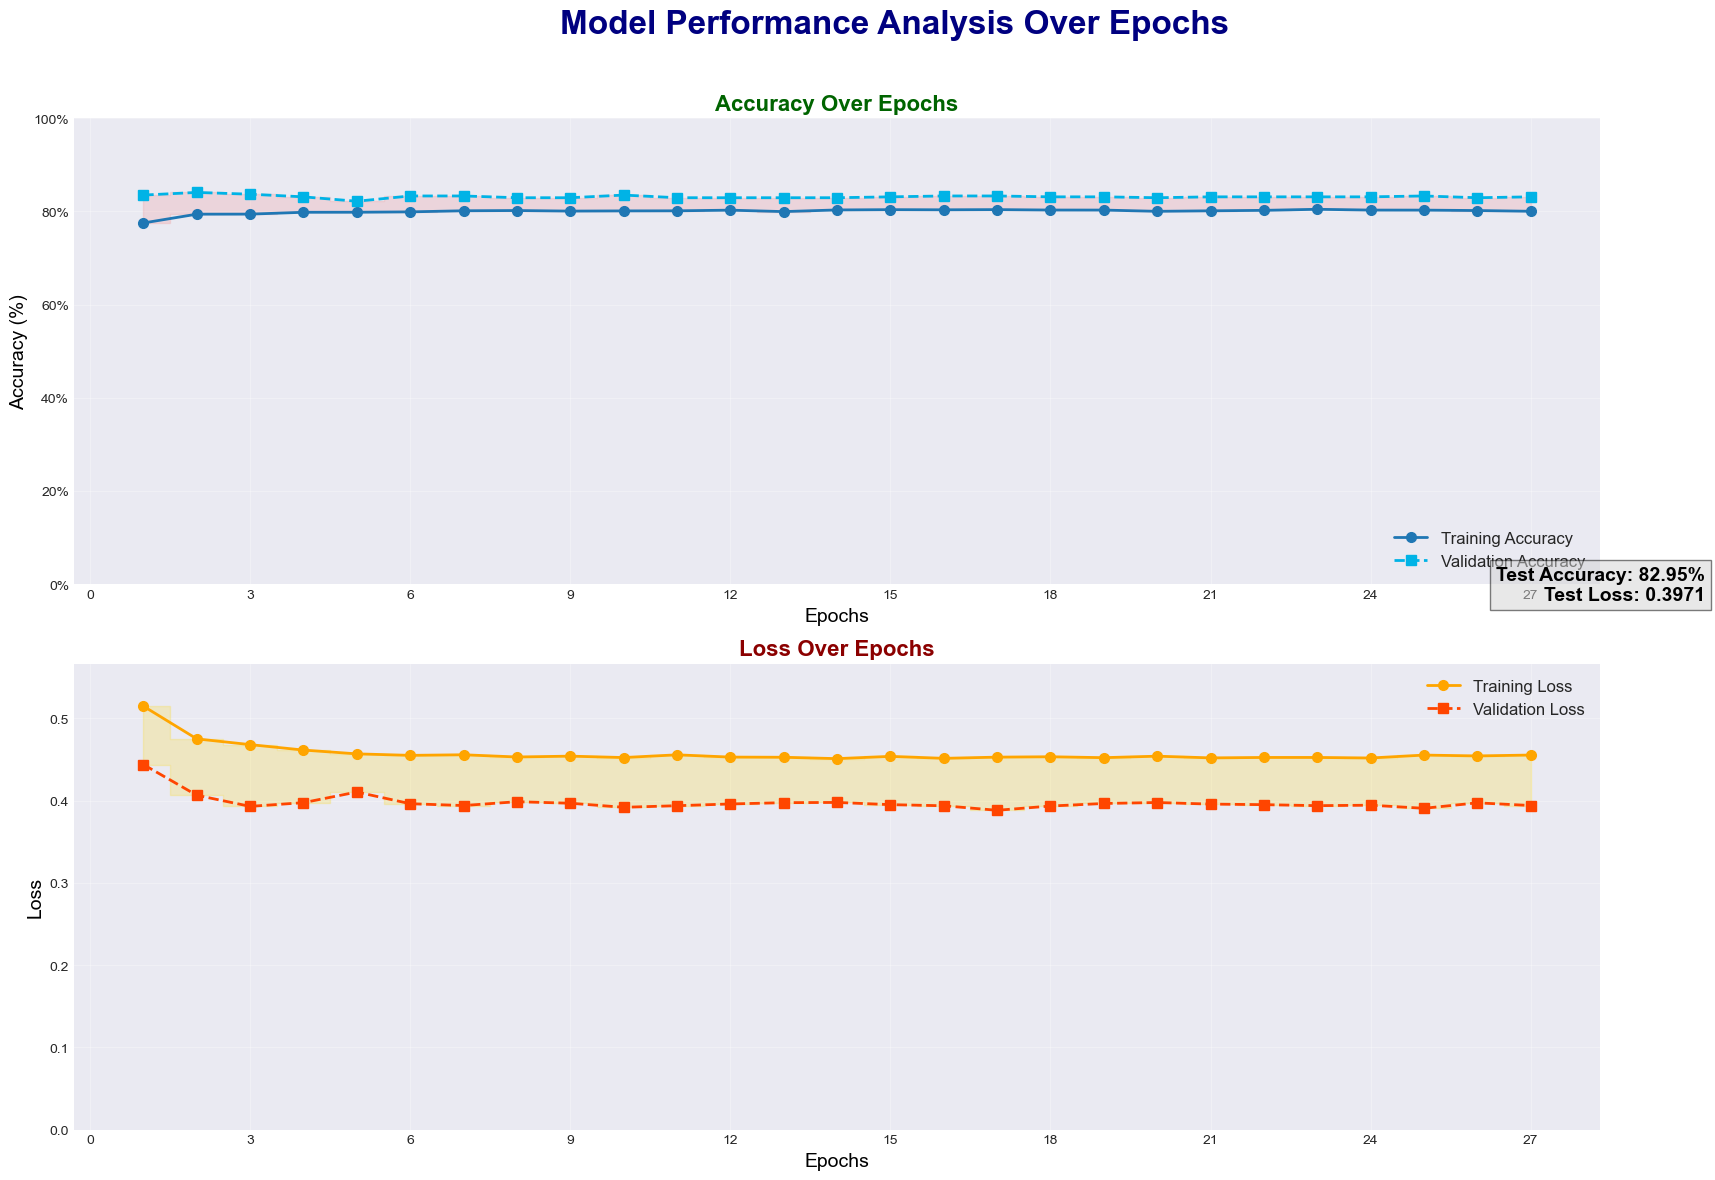

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


The above code is based on the PReLU activation function along with Relu

In [ ]:
def create_swish_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='swish', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='swish', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='swish', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='swish', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='swish', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='swish'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
swish_model = create_swish_model()
swish_model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_263 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_263 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_153 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_264 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_264 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_265 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
swish_model = create_swish_model()
history = swish_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 147s 230ms/step - loss: 0.4870 - accuracy: 0.7810 - val_loss: 0.3965 - val_accuracy: 0.8239
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.7976
Epoch 2: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 132s 209ms/step - loss: 0.4629 - accuracy: 0.7976 - val_loss: 0.4418 - val_accuracy: 0.7955
Epoch 3/40
633/633 [==============================] - 132s 209ms/step - loss: 0.4529 - accuracy: 0.7993 - val_loss: 0.3862 - val_accuracy: 0.8201
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.4479 - accuracy: 0.8008
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 131s 207ms/step - loss: 0.4479 - accuracy: 0.8008 - val_loss: 0.3976 - val_accuracy: 0.8144
Epoch 5/40
633/633 [==============================] - 137s 216ms/step - loss: 0.4449 - accuracy: 

In [ ]:

# Save the model
swish_model.save('model_swish.h5')
print("Model saved as model_swish.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = swish_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as model_swish.h5
Evaluating the model on the test data
33/33 [==============================] - 1s 40ms/step - loss: 0.3876 - accuracy: 0.8163
Test Loss: 0.3876
Test Accuracy: 0.8163


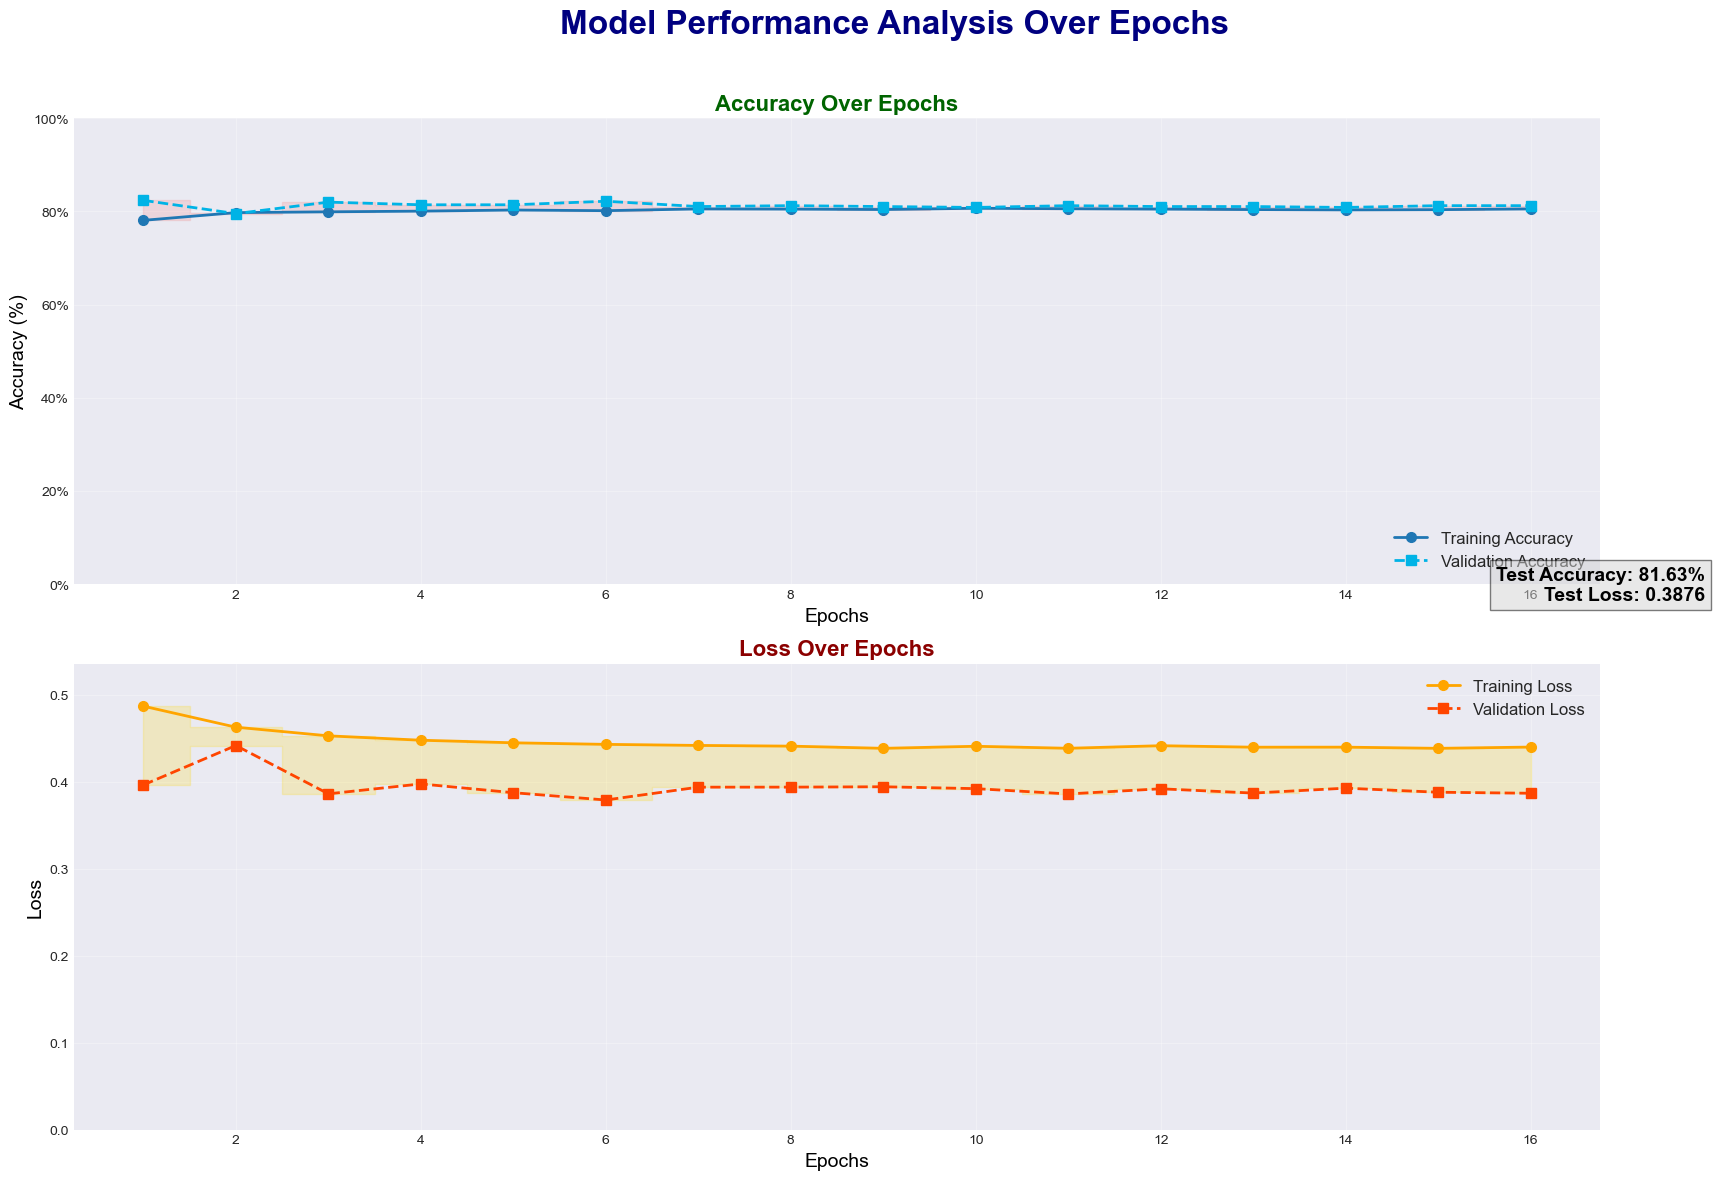

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


The above code is for the swish activation function

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Activation

def hard_swish(x):
    return x * tf.keras.activations.hard_sigmoid(x)

# Custom layer to include Hard Swish
class HardSwish(Activation):
    def __init__(self, **kwargs):
        super(HardSwish, self).__init__(hard_swish, **kwargs)


In [ ]:
def create_hard_swish_model():
    model = Sequential([
        Conv2D(16, (3, 3), padding='same', input_shape=(img_width, img_height, 1)),
        HardSwish(),  # Use Hard Swish here
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), padding='same'),
        HardSwish(),  # Use Hard Swish here
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), padding='same'),
        HardSwish(),  # Use Hard Swish here
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), padding='same'),
        HardSwish(),  # Use Hard Swish here
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), padding='same'),
        HardSwish(),  # Use Hard Swish here
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation=hard_swish),  # Use Hard Swish here
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
hard_swish_model = create_hard_swish_model()
hard_swish_model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_273 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 hard_swish_20 (HardSwish)   (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d_273 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_159 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_274 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 hard_swish_21 (HardSwish)   (None, 64, 64, 32)        0         
                                                     

In [ ]:

# Train the model
print("Training with combined dataset")
hard_swish_model = create_hard_swish_model()
history = hard_swish_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 157s 243ms/step - loss: 0.4890 - accuracy: 0.7749 - val_loss: 0.4026 - val_accuracy: 0.8239
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.7963
Epoch 2: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 138s 218ms/step - loss: 0.4611 - accuracy: 0.7963 - val_loss: 0.4152 - val_accuracy: 0.8106
Epoch 3/40
633/633 [==============================] - 136s 214ms/step - loss: 0.4514 - accuracy: 0.8022 - val_loss: 0.4089 - val_accuracy: 0.8125
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.4498 - accuracy: 0.8023
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 140s 221ms/step - loss: 0.4498 - accuracy: 0.8023 - val_loss: 0.3887 - val_accuracy: 0.8182
Epoch 5/40
633/633 [==============================] - 135s 213ms/step - loss: 0.4456 - accuracy: 

In [ ]:

# Save the model
hard_swish_model.save('model_hard_swish.h5')
print("Model saved as model_hard_swish.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = hard_swish_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as model_hard_swish.h5
Evaluating the model on the test data
33/33 [==============================] - 2s 46ms/step - loss: 0.3870 - accuracy: 0.8182
Test Loss: 0.3870
Test Accuracy: 0.8182


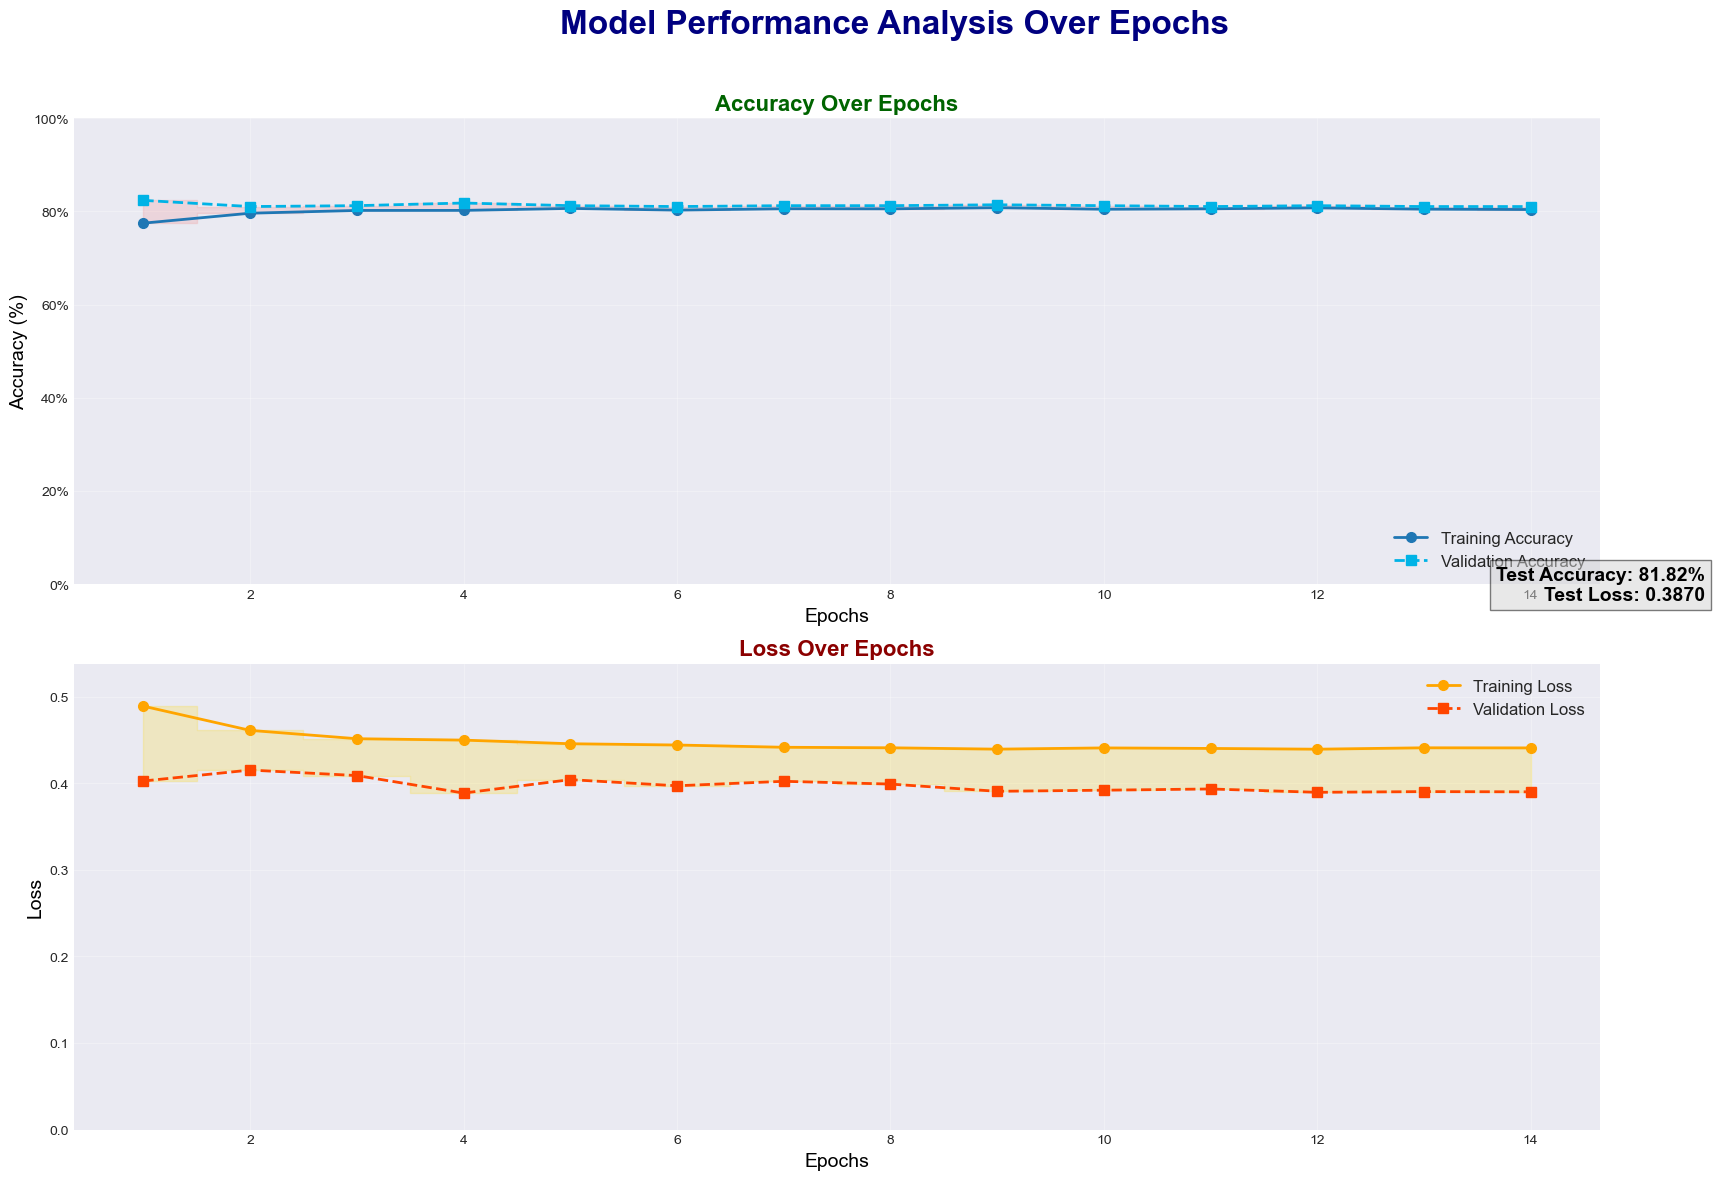

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


The above code is using hard_swish activation function

In [ ]:
def create_thresholded_relu_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation=ThresholdedReLU(theta=1.0), padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation=ThresholdedReLU(theta=1.0), padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation=ThresholdedReLU(theta=1.0), padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation=ThresholdedReLU(theta=1.0), padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation=ThresholdedReLU(theta=1.0), padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation=ThresholdedReLU(theta=1.0)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
thresholded_relu_model = create_thresholded_relu_model()
thresholded_relu_model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_283 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_283 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_165 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_284 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_284 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_285 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
thresholded_relu_model_model = create_thresholded_relu_model()
history = thresholded_relu_model_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 161s 251ms/step - loss: 0.6626 - accuracy: 0.6806 - val_loss: 0.6398 - val_accuracy: 0.6856
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.6330 - accuracy: 0.6819
Epoch 2: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 164s 260ms/step - loss: 0.6330 - accuracy: 0.6819 - val_loss: 0.6258 - val_accuracy: 0.6856
Epoch 3/40
633/633 [==============================] - 164s 259ms/step - loss: 0.6273 - accuracy: 0.6820 - val_loss: 0.6268 - val_accuracy: 0.6818
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.6263 - accuracy: 0.6819
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 168s 266ms/step - loss: 0.6263 - accuracy: 0.6819 - val_loss: 0.6247 - val_accuracy: 0.6837
Epoch 5/40
633/633 [==============================] - 173s 273ms/step - loss: 0.6257 - accuracy: 

In [ ]:

# Save the model
thresholded_relu_model_model.save('model_thresholded_Relu.h5')
print("Model saved as model_thresholded_Relu.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = thresholded_relu_model_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as model_thresholded_Relu.h5
Evaluating the model on the test data
33/33 [==============================] - 2s 46ms/step - loss: 0.6271 - accuracy: 0.6799
Test Loss: 0.6271
Test Accuracy: 0.6799


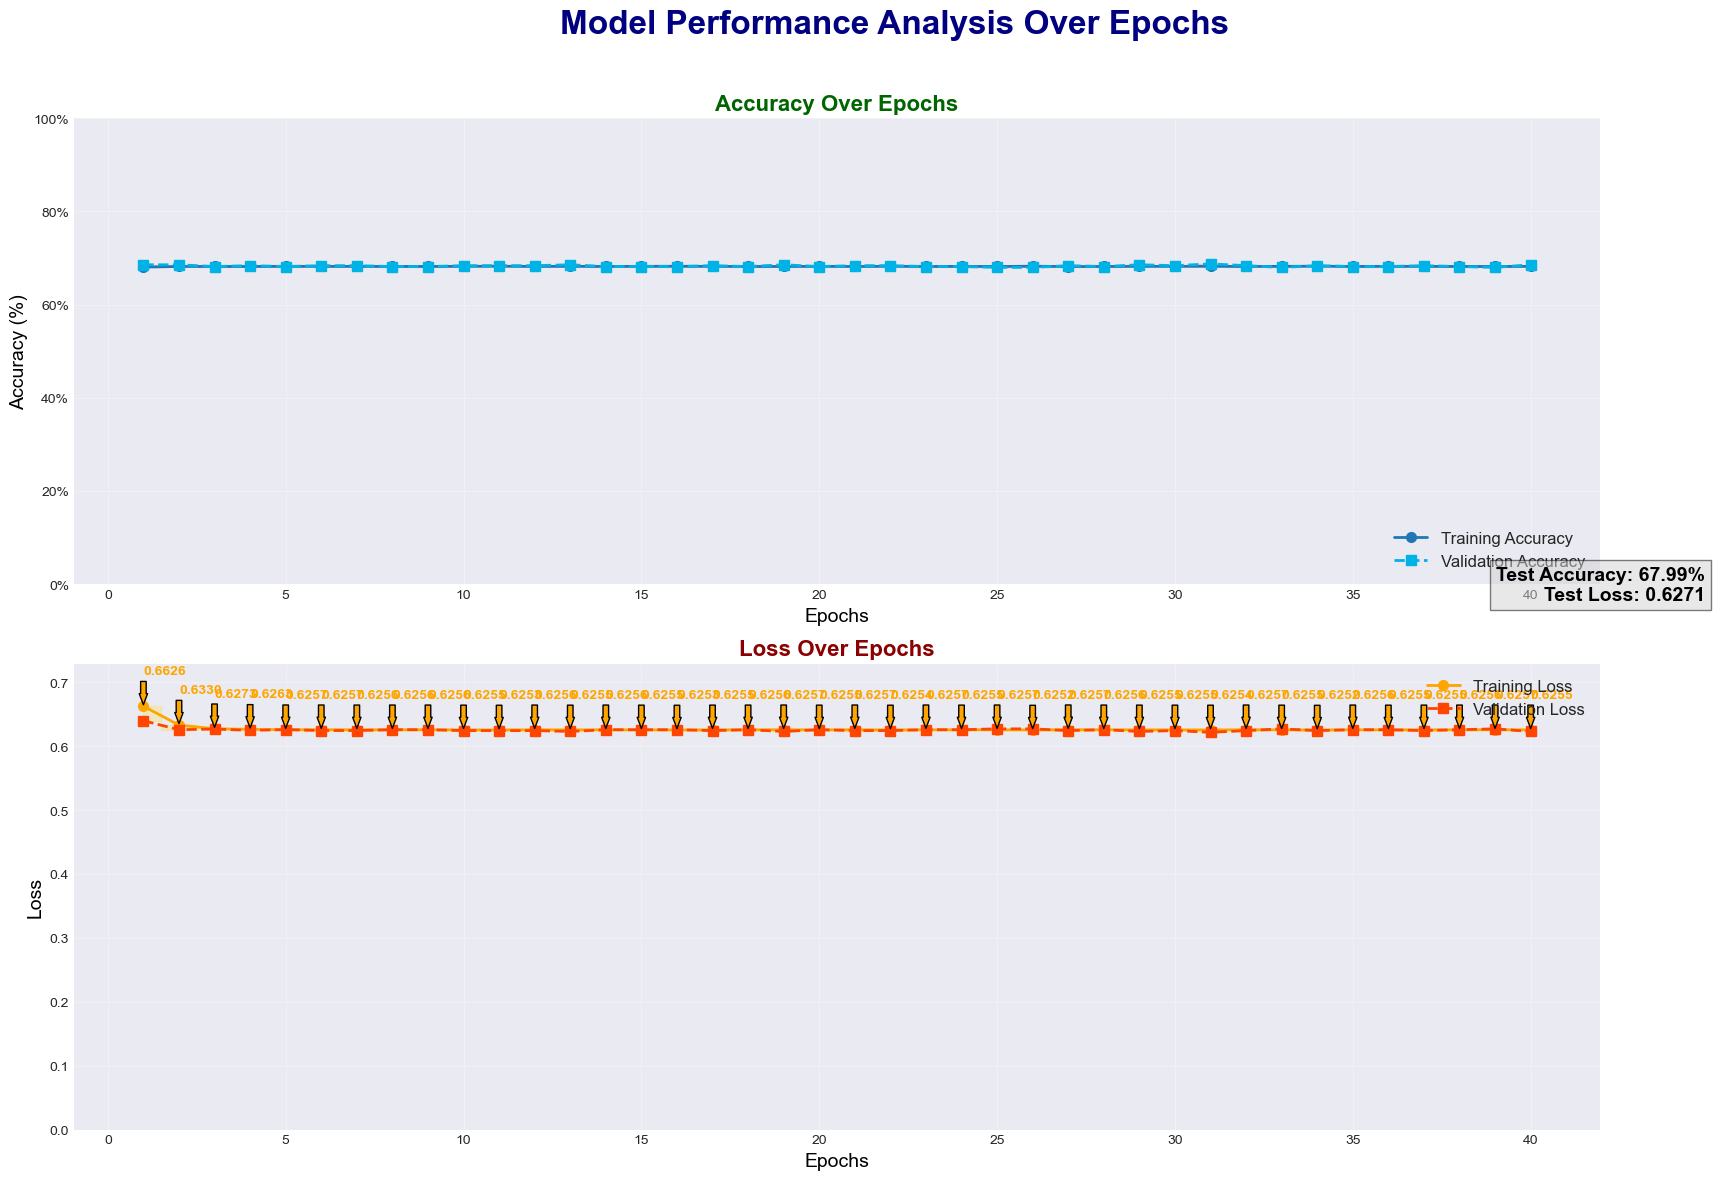

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


In the above code the activation function used is Thresholded Relu

In [ ]:
# CNN model with GELU + sigmoid
def create_sigmoid_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='sigmoid', padding='same'),  # Use sigmoid here
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='sigmoid', padding='same'),  # Use sigmoid here
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='sigmoid'),  # Use sigmoid here
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
sigmoid_model = create_sigmoid_model()
sigmoid_model.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_293 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_293 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_171 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_294 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_294 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_295 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
sigmoid_model = create_sigmoid_model()
history = sigmoid_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 135s 209ms/step - loss: 0.5470 - accuracy: 0.7401 - val_loss: 0.3744 - val_accuracy: 0.8390
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.7956
Epoch 2: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 131s 207ms/step - loss: 0.4704 - accuracy: 0.7956 - val_loss: 0.4216 - val_accuracy: 0.8068
Epoch 3/40
633/633 [==============================] - 134s 211ms/step - loss: 0.4591 - accuracy: 0.7983 - val_loss: 0.3836 - val_accuracy: 0.8277
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.4563 - accuracy: 0.7996
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 134s 211ms/step - loss: 0.4563 - accuracy: 0.7996 - val_loss: 0.3934 - val_accuracy: 0.8144
Epoch 5/40
633/633 [==============================] - 135s 213ms/step - loss: 0.4552 - accuracy: 

In [ ]:

# Save the model
sigmoid_model.save('sigmoid_model.h5')
print("Model saved as sigmoid_model.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = sigmoid_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as sigmoid_model.h5
Evaluating the model on the test data
33/33 [==============================] - 1s 42ms/step - loss: 0.3777 - accuracy: 0.8371
Test Loss: 0.3777
Test Accuracy: 0.8371


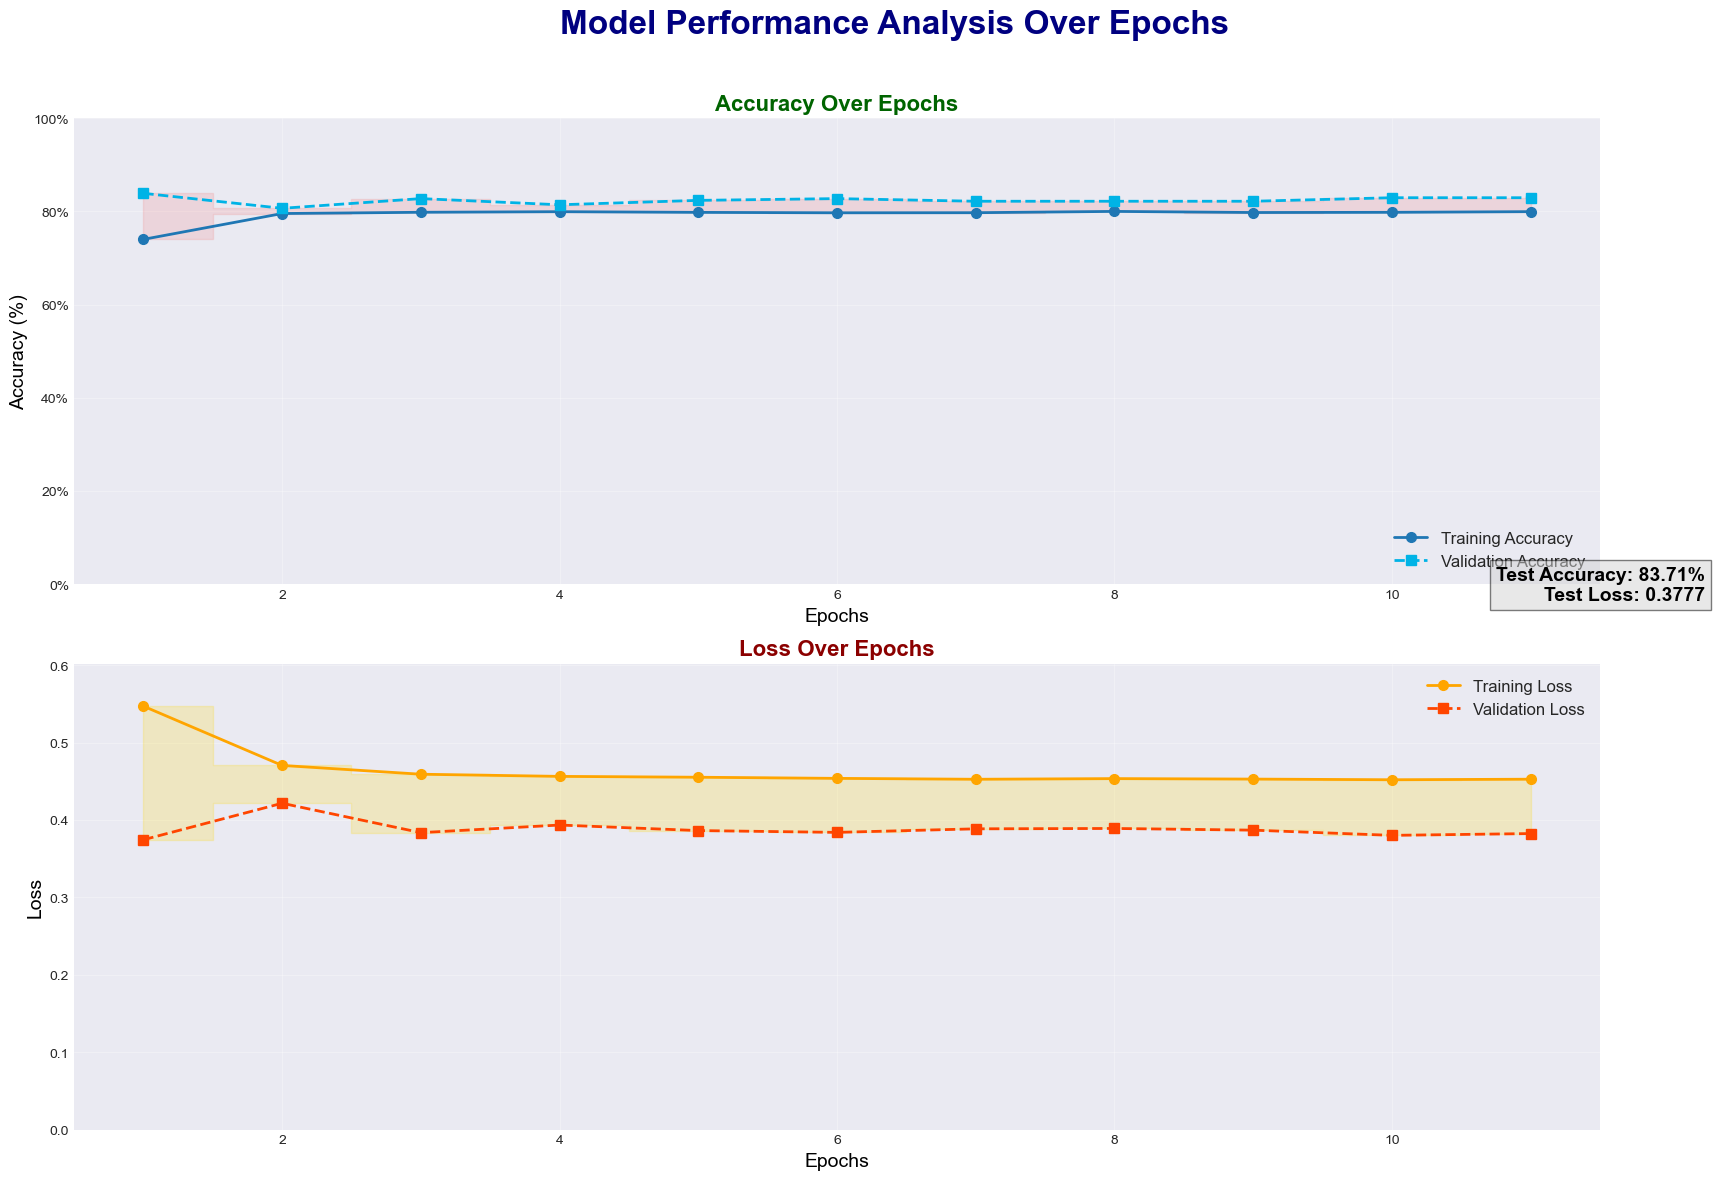

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


The above code will be using the activation function of sigmoid

In [ ]:
def create_relu_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
relu_model = create_relu_model()
relu_model.summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_303 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_303 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_177 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_304 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_304 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_305 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
relu_model = create_relu_model()
history = relu_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - ETA: 0s - loss: 0.4964 - accuracy: 0.7821
Epoch 1: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 147s 229ms/step - loss: 0.4964 - accuracy: 0.7821 - val_loss: 0.4060 - val_accuracy: 0.8314
Epoch 2/40
633/633 [==============================] - 146s 231ms/step - loss: 0.4635 - accuracy: 0.7988 - val_loss: 0.3987 - val_accuracy: 0.8220
Epoch 3/40
633/633 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.8013
Epoch 3: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 161s 255ms/step - loss: 0.4608 - accuracy: 0.8013 - val_loss: 0.4002 - val_accuracy: 0.8333
Epoch 4/40
633/633 [==============================] - 165s 260ms/step - loss: 0.4543 - accuracy: 0.7987 - val_loss: 0.3874 - val_accuracy: 0.8295
Epoch 5/40
633/633 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.8011
E

In [ ]:

# Save the model
relu_model.save('relu_model.h5')
print("Model saved as relu_model.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = relu_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as relu_model.h5
Evaluating the model on the test data
33/33 [==============================] - 1s 41ms/step - loss: 0.3779 - accuracy: 0.8295
Test Loss: 0.3779
Test Accuracy: 0.8295


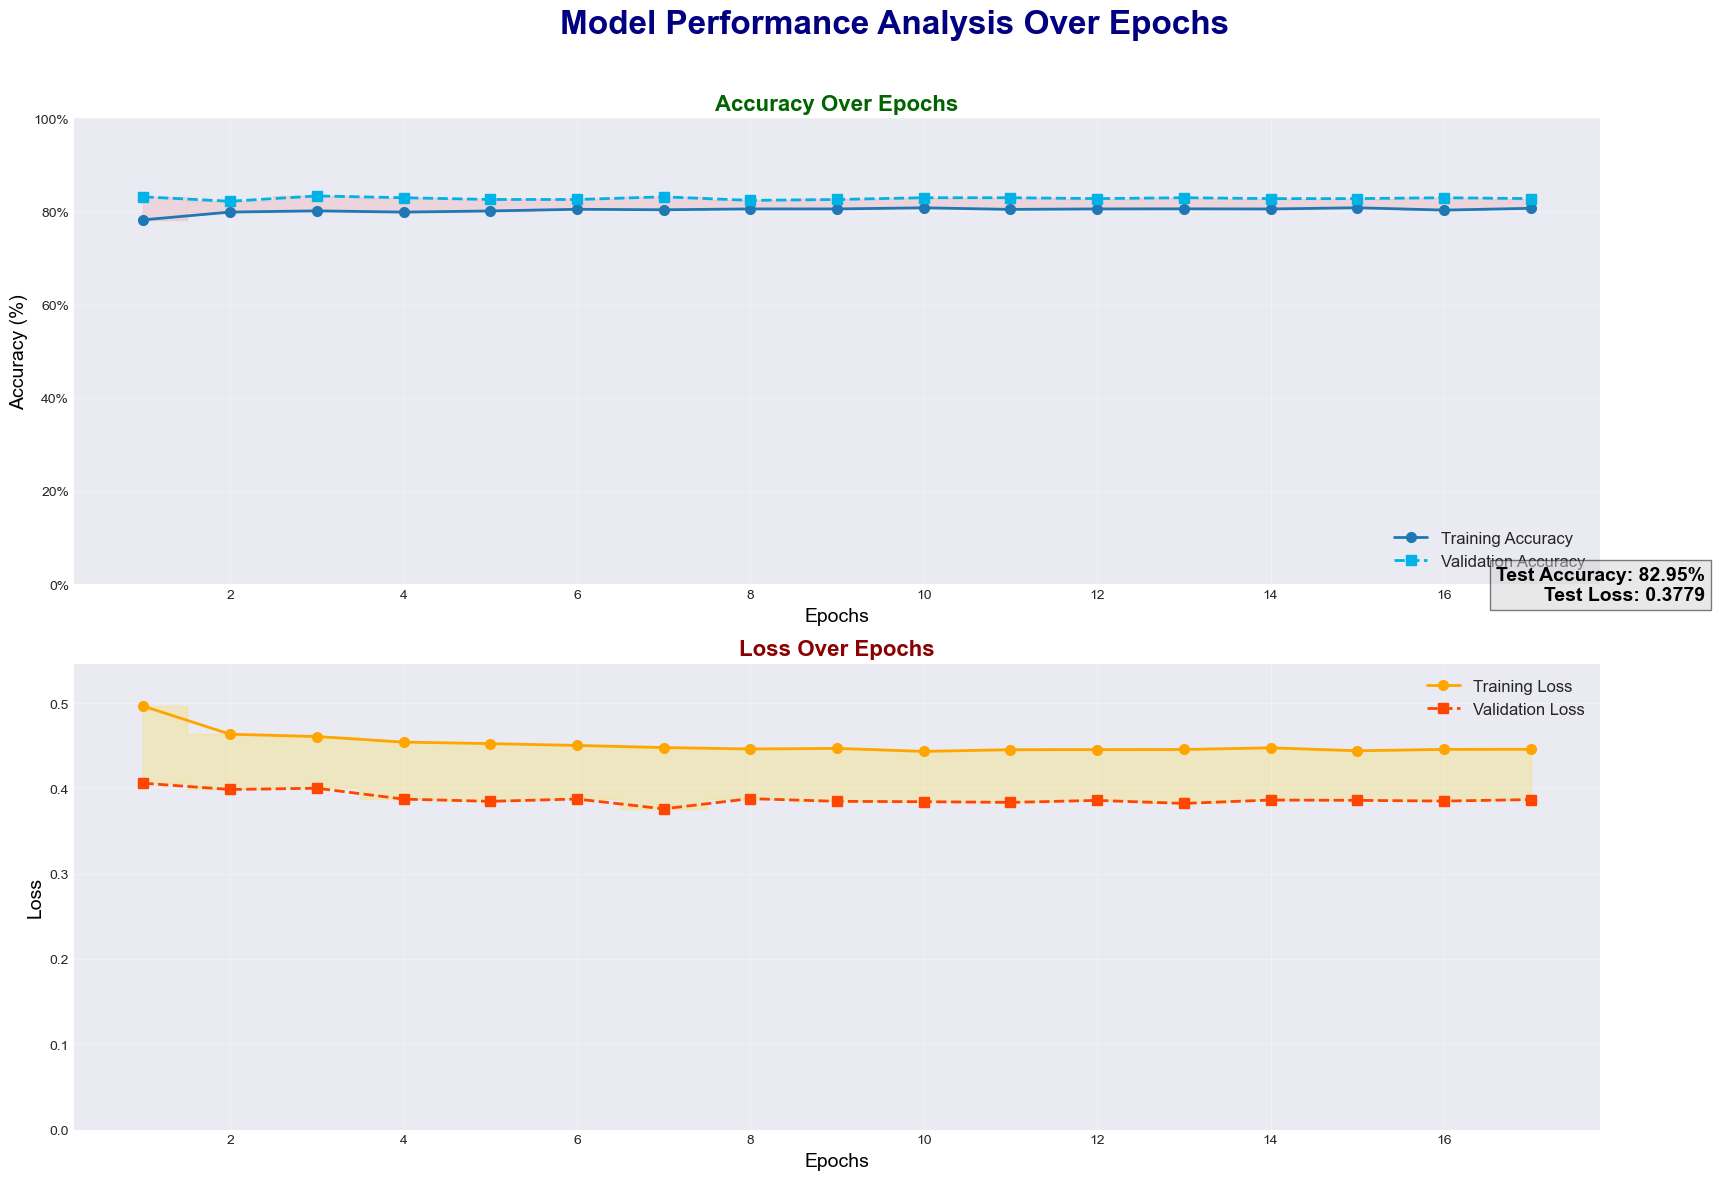

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


The above code is a basic relu activation code

In [ ]:
def create_hard_sigmoid_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
hard_sigmoid_model = create_hard_sigmoid_model()
hard_sigmoid_model.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_313 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_313 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_183 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_314 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_314 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_315 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
hard_sigmoid_model = create_relu_model()
history = hard_sigmoid_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 149s 233ms/step - loss: 0.5263 - accuracy: 0.7722 - val_loss: 0.4283 - val_accuracy: 0.8409
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.4923 - accuracy: 0.7919
Epoch 2: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 135s 214ms/step - loss: 0.4923 - accuracy: 0.7919 - val_loss: 0.4717 - val_accuracy: 0.7860
Epoch 3/40
633/633 [==============================] - 133s 210ms/step - loss: 0.4671 - accuracy: 0.7983 - val_loss: 0.4044 - val_accuracy: 0.8295
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.4646 - accuracy: 0.8021
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 137s 216ms/step - loss: 0.4646 - accuracy: 0.8021 - val_loss: 0.4080 - val_accuracy: 0.8220
Epoch 5/40
633/633 [==============================] - 132s 209ms/step - loss: 0.4576 - accuracy: 

In [ ]:

# Save the model
hard_sigmoid_model.save('hard_sigmoid_model.h5')
print("Model saved as hard_sigmoid_model.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = hard_sigmoid_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as hard_sigmoid_model.h5
Evaluating the model on the test data
33/33 [==============================] - 1s 41ms/step - loss: 0.3909 - accuracy: 0.8352
Test Loss: 0.3909
Test Accuracy: 0.8352


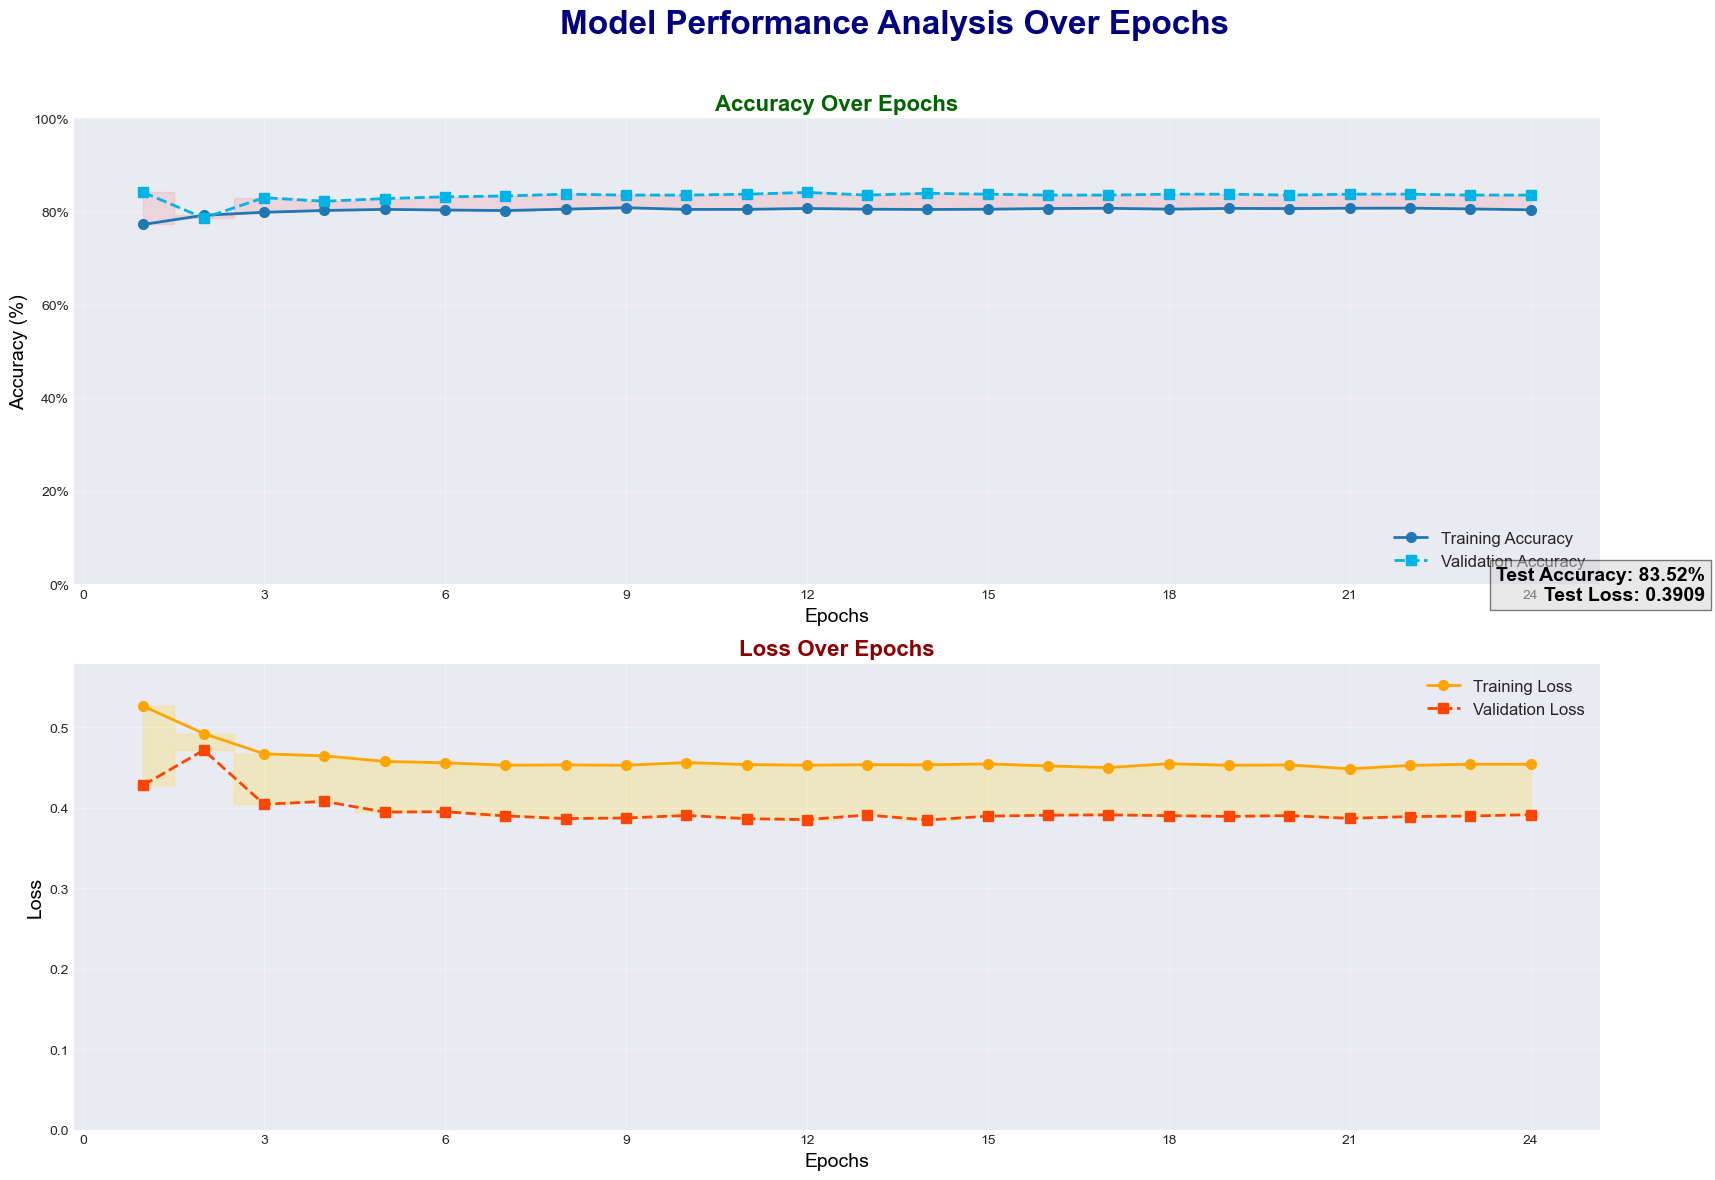

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


The above code uses hard sigmoid in the final layer instead of the normal sigmoid which is computationally heavier and slower

In [ ]:
# CNN model with sigmoid
def create_sigmoid_relu_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='sigmoid', padding='same'),  # Use GELU here
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='sigmoid', padding='same'),  # Use GELU here
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='sigmoid'),  # Use GELU here
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
sigmoid_relu_model = create_sigmoid_relu_model()
sigmoid_relu_model.summary()

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_323 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_323 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_189 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_324 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_324 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_325 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
sigmoid_relu_model = create_sigmoid_relu_model()
history = sigmoid_relu_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 146s 229ms/step - loss: 0.5255 - accuracy: 0.7531 - val_loss: 0.3930 - val_accuracy: 0.8371
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.7975
Epoch 2: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 138s 217ms/step - loss: 0.4658 - accuracy: 0.7975 - val_loss: 0.4108 - val_accuracy: 0.8125
Epoch 3/40
633/633 [==============================] - 138s 218ms/step - loss: 0.4596 - accuracy: 0.7971 - val_loss: 0.3879 - val_accuracy: 0.8201
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.7975
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 135s 214ms/step - loss: 0.4570 - accuracy: 0.7975 - val_loss: 0.3728 - val_accuracy: 0.8333
Epoch 5/40
633/633 [==============================] - 138s 218ms/step - loss: 0.4532 - accuracy: 

In [ ]:

# Save the model
sigmoid_relu_model.save('sigmoid_relu_model.h5')
print("Model saved as sigmoid_relu_model.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = sigmoid_relu_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as sigmoid_relu_model.h5
Evaluating the model on the test data
33/33 [==============================] - 1s 38ms/step - loss: 0.3739 - accuracy: 0.8314
Test Loss: 0.3739
Test Accuracy: 0.8314


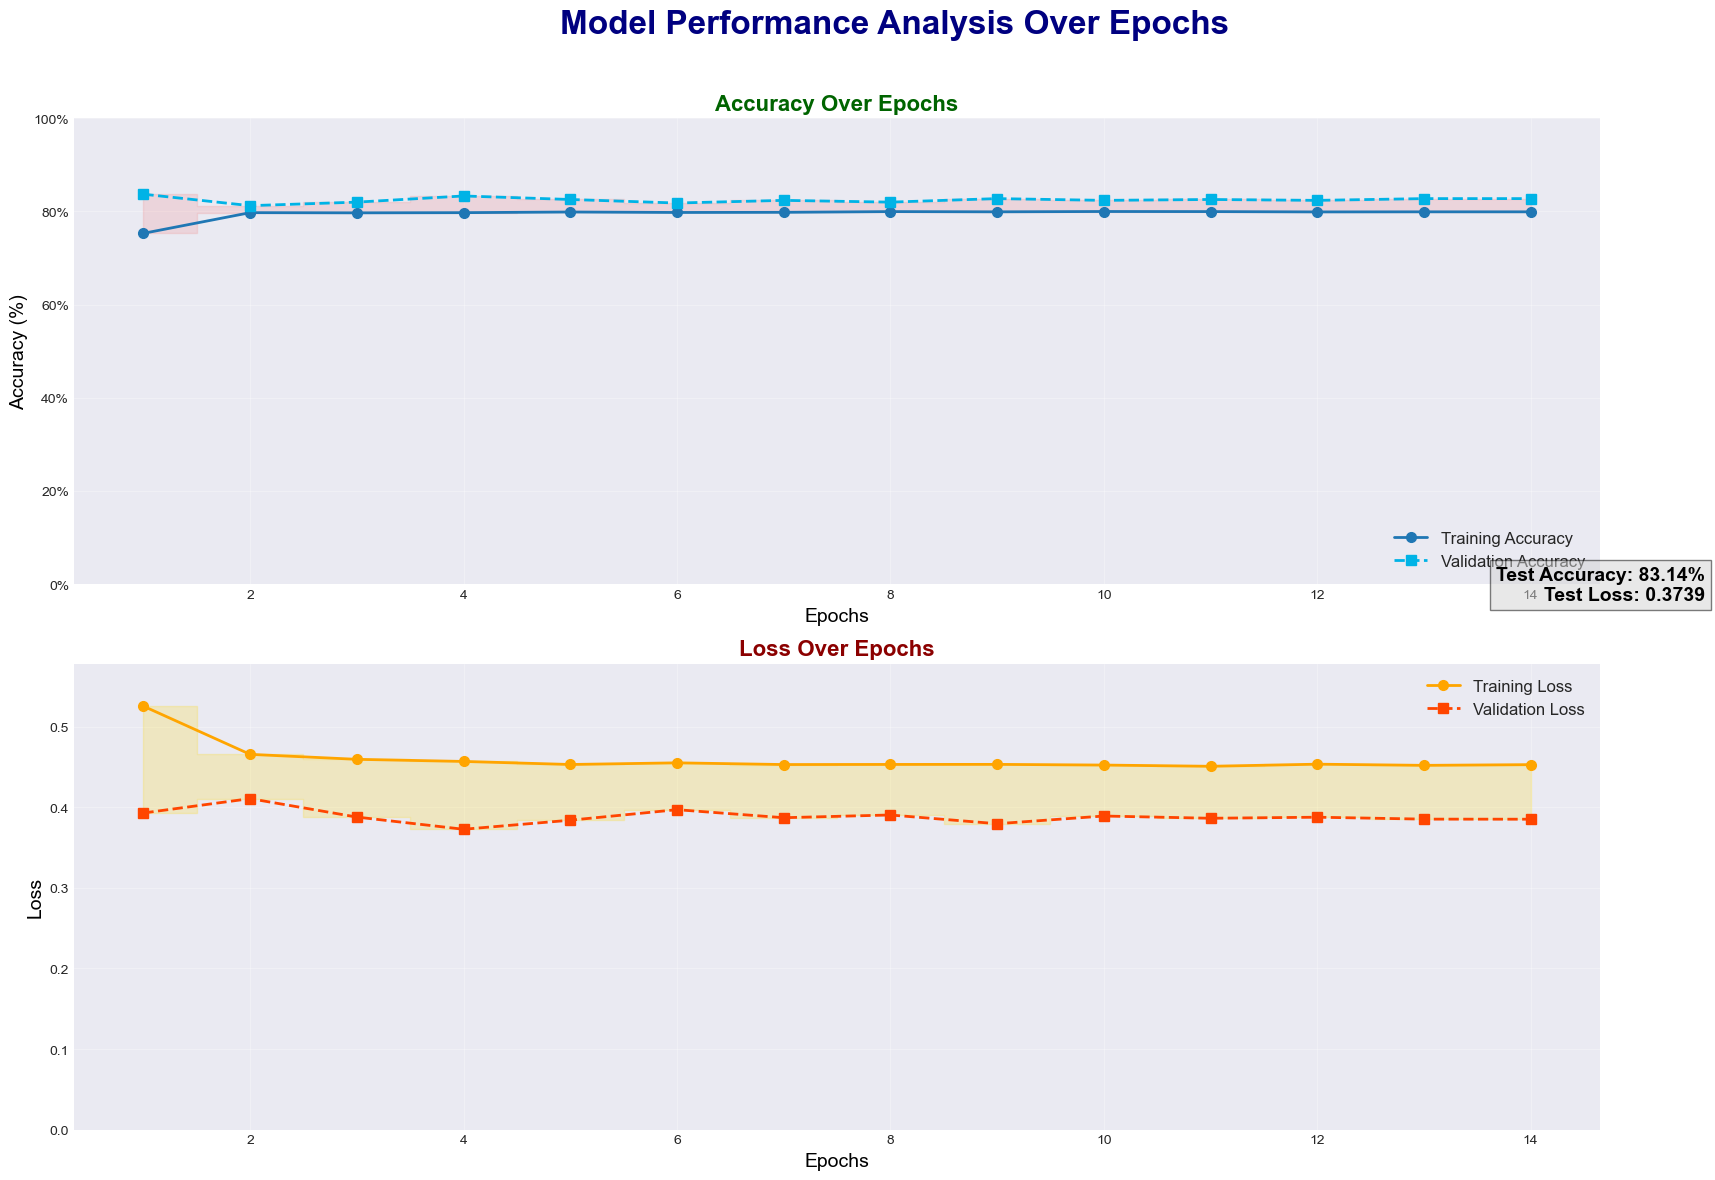

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


The above code uses sigmoid and relu activations

In [ ]:
# CNN model with sigmoid
def create_combo_1_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='softsign', padding='same'),  
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='softsign', padding='same'),  
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='softsign', padding='same'),  #remove if needed
        MaxPooling2D((2, 2)),#remove if needed
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='relu'),  
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
combo_1_model = create_combo_1_model()
combo_1_model.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_333 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_333 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_195 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_334 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_334 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_335 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
combo_1_model = create_combo_1_model()
history = combo_1_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 175s 274ms/step - loss: 0.4878 - accuracy: 0.7850 - val_loss: 0.4175 - val_accuracy: 0.8125
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.4689 - accuracy: 0.7969
Epoch 2: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 161s 255ms/step - loss: 0.4689 - accuracy: 0.7969 - val_loss: 0.3852 - val_accuracy: 0.8428
Epoch 3/40
633/633 [==============================] - 170s 269ms/step - loss: 0.4531 - accuracy: 0.8052 - val_loss: 0.4052 - val_accuracy: 0.8163
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.4477 - accuracy: 0.8070
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 159s 252ms/step - loss: 0.4477 - accuracy: 0.8070 - val_loss: 0.4249 - val_accuracy: 0.8106
Epoch 5/40
633/633 [==============================] - 150s 237ms/step - loss: 0.4422 - accuracy: 

In [ ]:

# Save the model
combo_1_model.save('combo_1_model.h5')
print("Model saved as combo_1_model.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = combo_1_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as combo_1_model.h5
Evaluating the model on the test data
33/33 [==============================] - 1s 44ms/step - loss: 0.3814 - accuracy: 0.8182
Test Loss: 0.3814
Test Accuracy: 0.8182


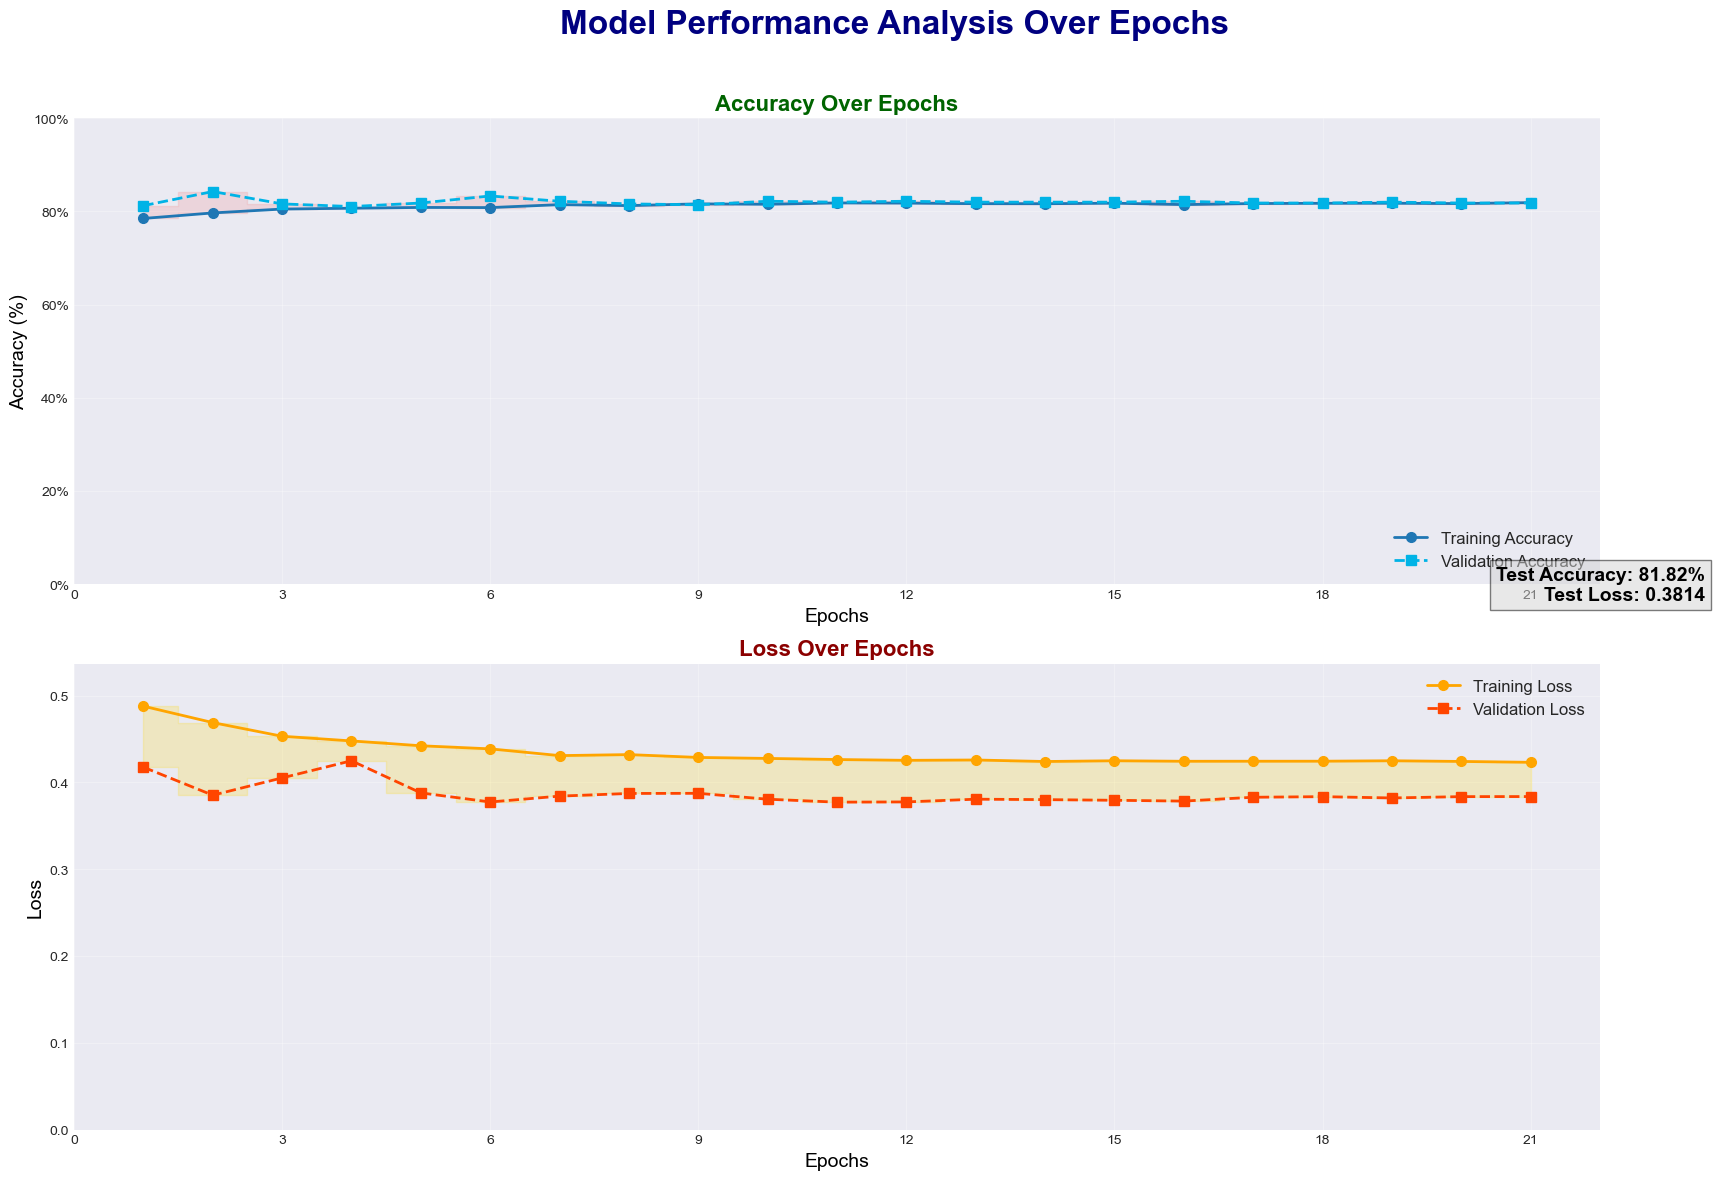

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


Combo 1 above

In [ ]:
# CNN model
def create_combo_2_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='swish', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='softsign', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='softsign', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
combo_2_model = create_combo_2_model()
combo_2_model.summary()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_345 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_345 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_201 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_346 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_346 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_347 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
combo_2_model = create_combo_2_model()
history = combo_2_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.7831
Epoch 1: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 159s 248ms/step - loss: 0.4954 - accuracy: 0.7831 - val_loss: 0.4665 - val_accuracy: 0.8295
Epoch 2/40
633/633 [==============================] - 147s 232ms/step - loss: 0.4581 - accuracy: 0.8006 - val_loss: 0.3647 - val_accuracy: 0.8542
Epoch 3/40
633/633 [==============================] - 159s 251ms/step - loss: 0.4510 - accuracy: 0.8020 - val_loss: 0.3885 - val_accuracy: 0.8277
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.4492 - accuracy: 0.8024
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 171s 271ms/step - loss: 0.4492 - accuracy: 0.8024 - val_loss: 0.3797 - val_accuracy: 0.8220
Epoch 5/40
633/633 [==============================] - 174s 275ms/step - loss: 0.4429 - accuracy: 

In [ ]:

# Save the model
combo_2_model.save('combo_2_model.h5')
print("Model saved as combo_2_model.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = combo_2_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as combo_2_model.h5
Evaluating the model on the test data
33/33 [==============================] - 1s 43ms/step - loss: 0.3673 - accuracy: 0.8542
Test Loss: 0.3673
Test Accuracy: 0.8542


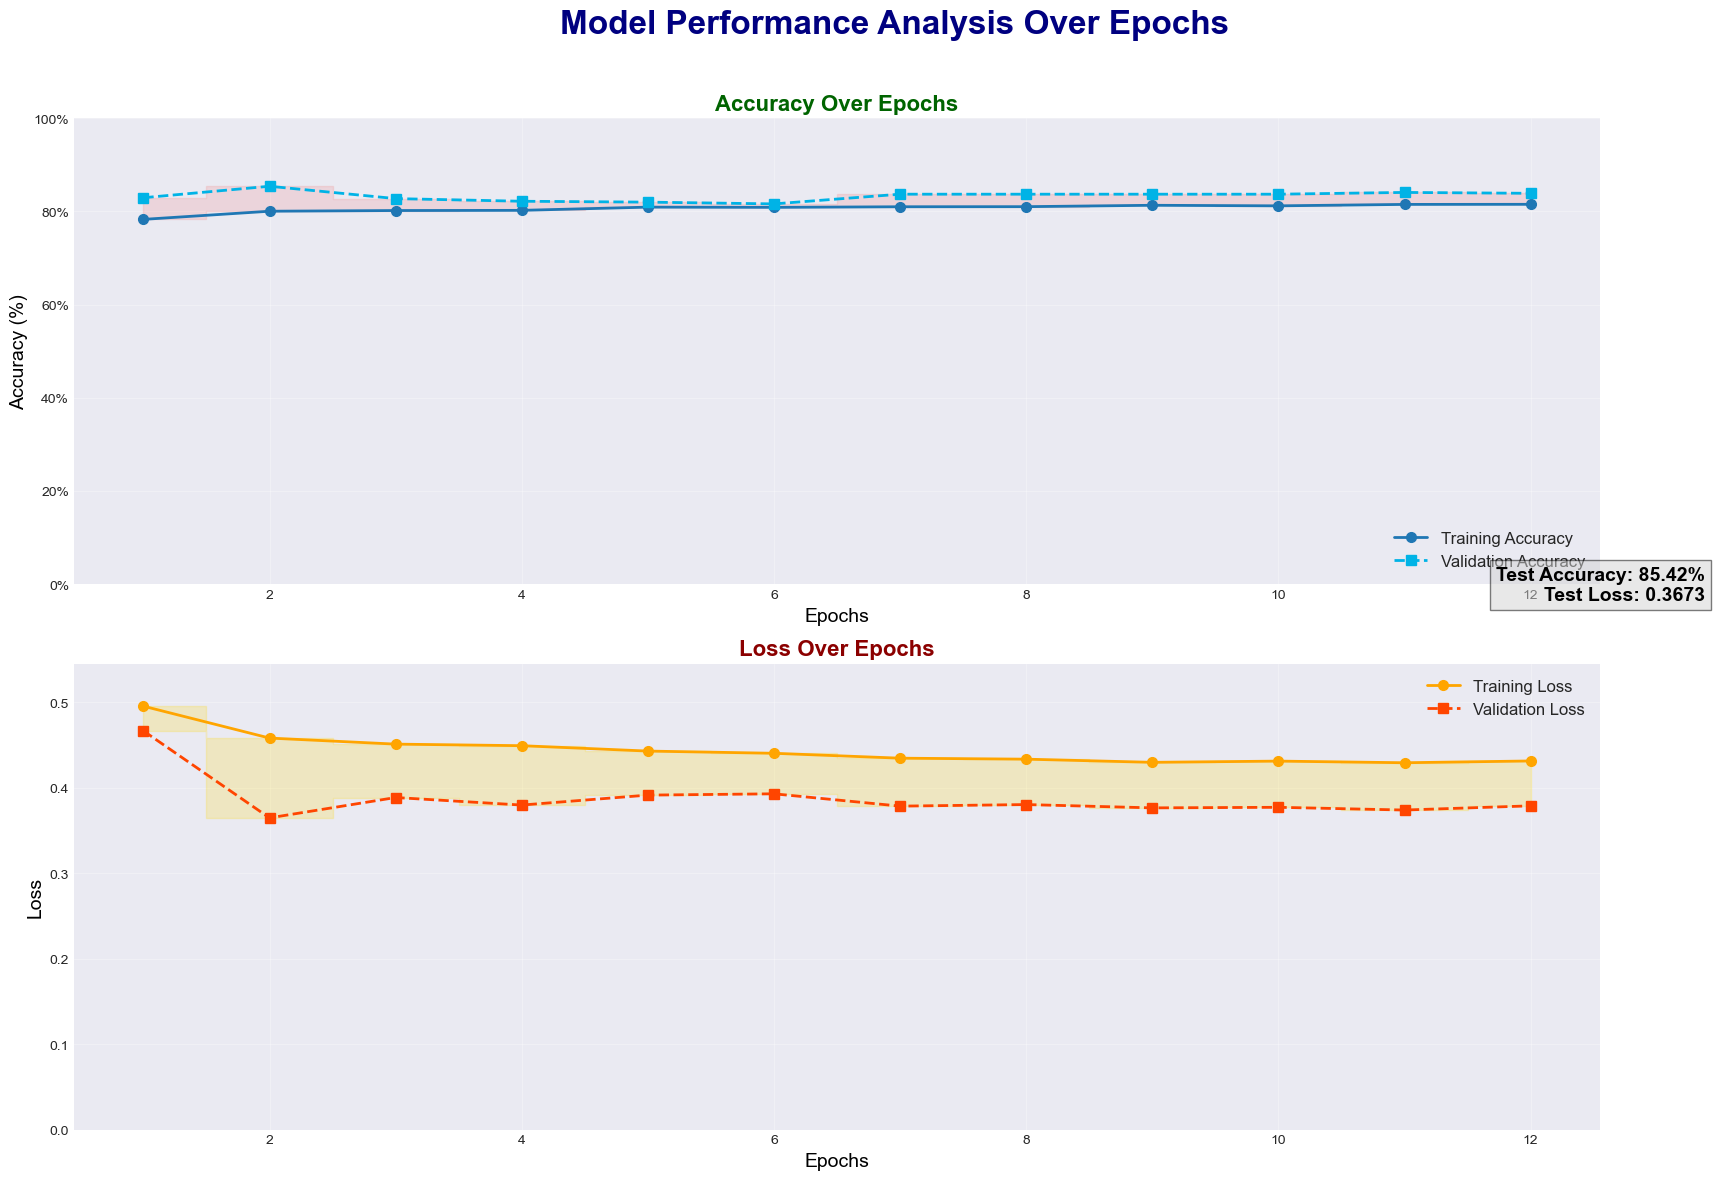

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


Combo 2 above

In [ ]:
# CNN model
def create_combo_3_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='swish', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='gelu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='softsign', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='softsign', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='hard_sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
combo_3_model = create_combo_3_model()
combo_3_model.summary()

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_357 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_357 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_207 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_358 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_358 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_359 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
combo_3_model = create_combo_3_model()
history = combo_3_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 185s 290ms/step - loss: 0.6380 - accuracy: 0.6827 - val_loss: 0.5595 - val_accuracy: 0.6818
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.6909
Epoch 2: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 202s 319ms/step - loss: 0.6668 - accuracy: 0.6909 - val_loss: 0.5690 - val_accuracy: 0.6837
Epoch 3/40
633/633 [==============================] - 192s 303ms/step - loss: 0.5972 - accuracy: 0.7050 - val_loss: 0.4398 - val_accuracy: 0.8447
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.5407 - accuracy: 0.7655
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 145s 229ms/step - loss: 0.5407 - accuracy: 0.7655 - val_loss: 0.4039 - val_accuracy: 0.8352
Epoch 5/40
633/633 [==============================] - 151s 238ms/step - loss: 0.5043 - accuracy: 

In [ ]:

# Save the model
combo_3_model.save('combo_3_model.h5')
print("Model saved as combo_3_model.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = combo_3_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as combo_3_model.h5
Evaluating the model on the test data
33/33 [==============================] - 2s 59ms/step - loss: 0.4011 - accuracy: 0.8371
Test Loss: 0.4011
Test Accuracy: 0.8371


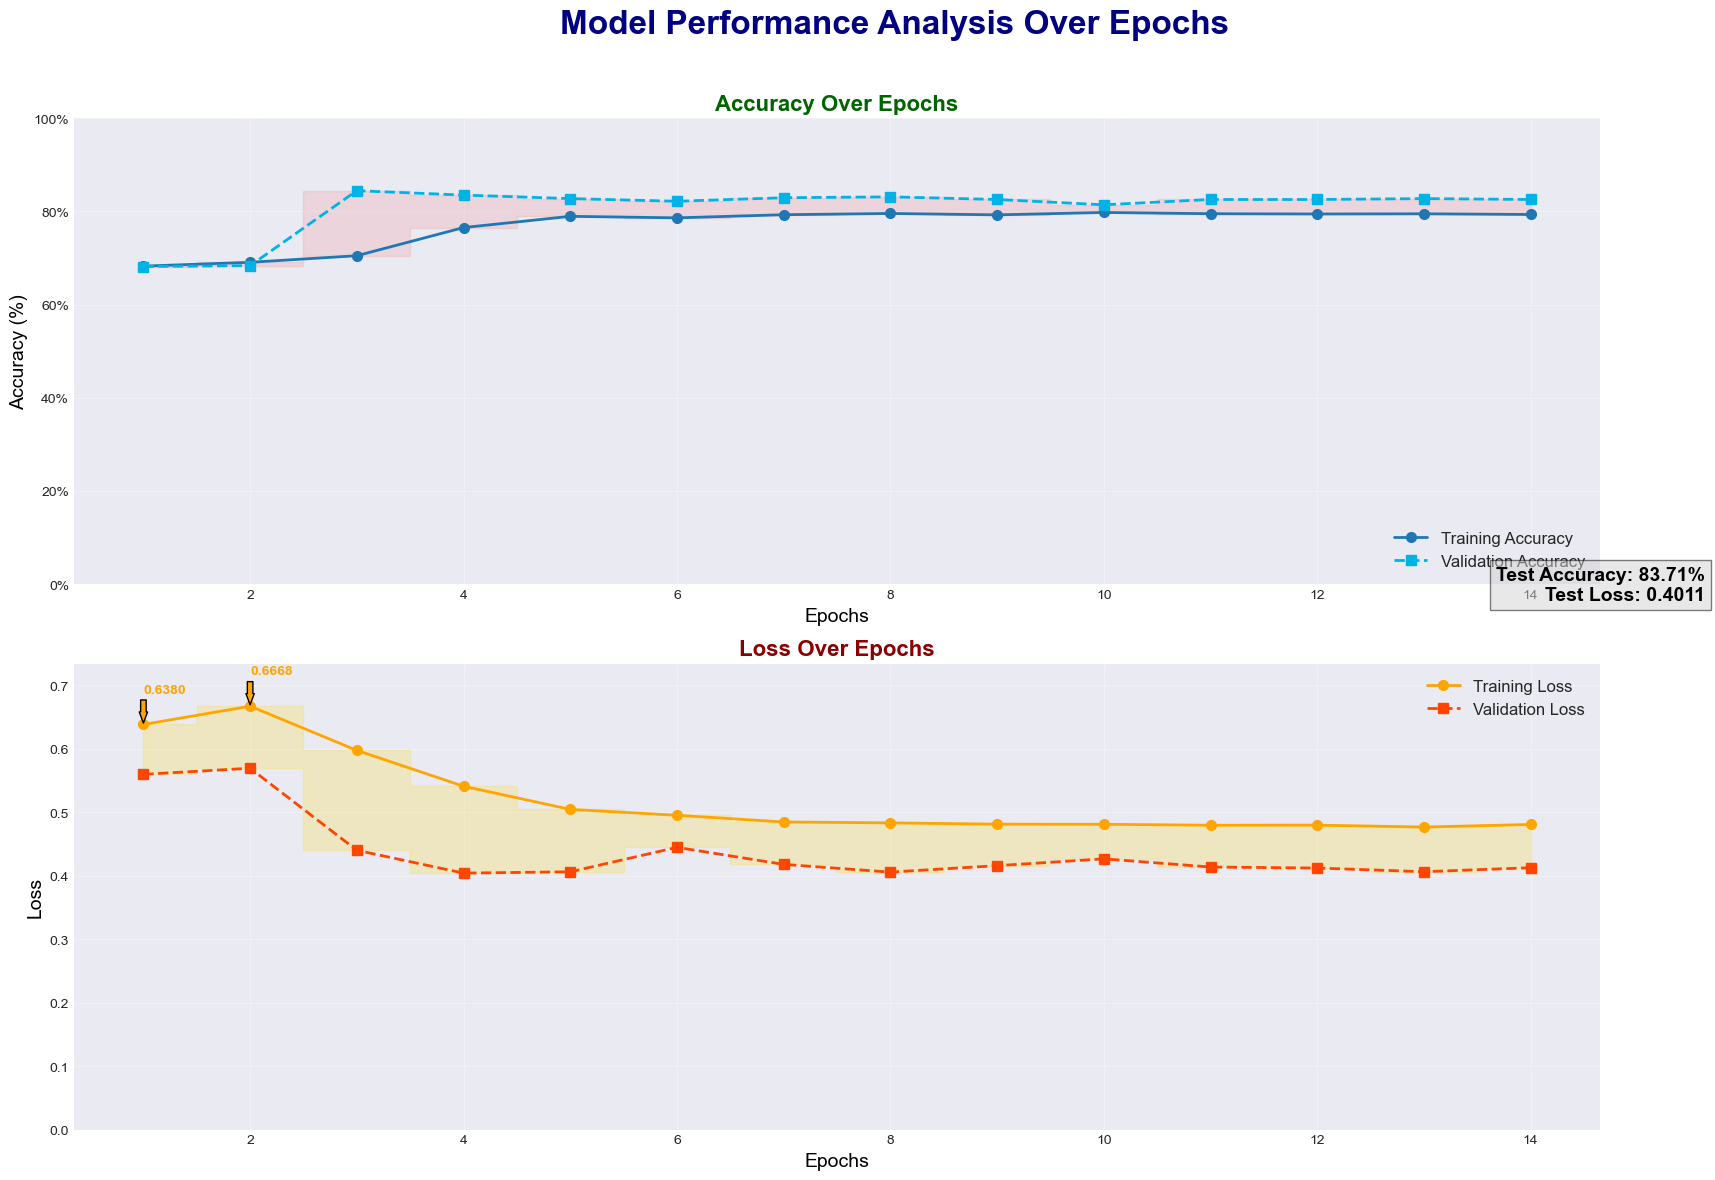

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


Combo 3 model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

def create_combo_4_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.3), padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.3), padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

The value of Alpha can be modified accordingly to see which gives the best weights

In [ ]:
combo_4_model = create_combo_4_model()
combo_4_model.summary()

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_369 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_369 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_213 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_370 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_370 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_371 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
combo_4_model = create_combo_4_model()
history = combo_4_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 163s 256ms/step - loss: 0.5032 - accuracy: 0.7788 - val_loss: 0.4770 - val_accuracy: 0.7784
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.7991
Epoch 2: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 154s 244ms/step - loss: 0.4699 - accuracy: 0.7991 - val_loss: 0.4045 - val_accuracy: 0.8201
Epoch 3/40
633/633 [==============================] - 165s 260ms/step - loss: 0.4575 - accuracy: 0.8013 - val_loss: 0.3911 - val_accuracy: 0.8201
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.4514 - accuracy: 0.8013
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 158s 250ms/step - loss: 0.4514 - accuracy: 0.8013 - val_loss: 0.3754 - val_accuracy: 0.8333
Epoch 5/40
633/633 [==============================] - 151s 236ms/step - loss: 0.4494 - accuracy: 

In [ ]:

# Save the model
combo_4_model.save('combo_4_model.h5')
print("Model saved as combo_4_model.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = combo_4_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as combo_4_model.h5
Evaluating the model on the test data
33/33 [==============================] - 2s 45ms/step - loss: 0.3765 - accuracy: 0.8371
Test Loss: 0.3765
Test Accuracy: 0.8371


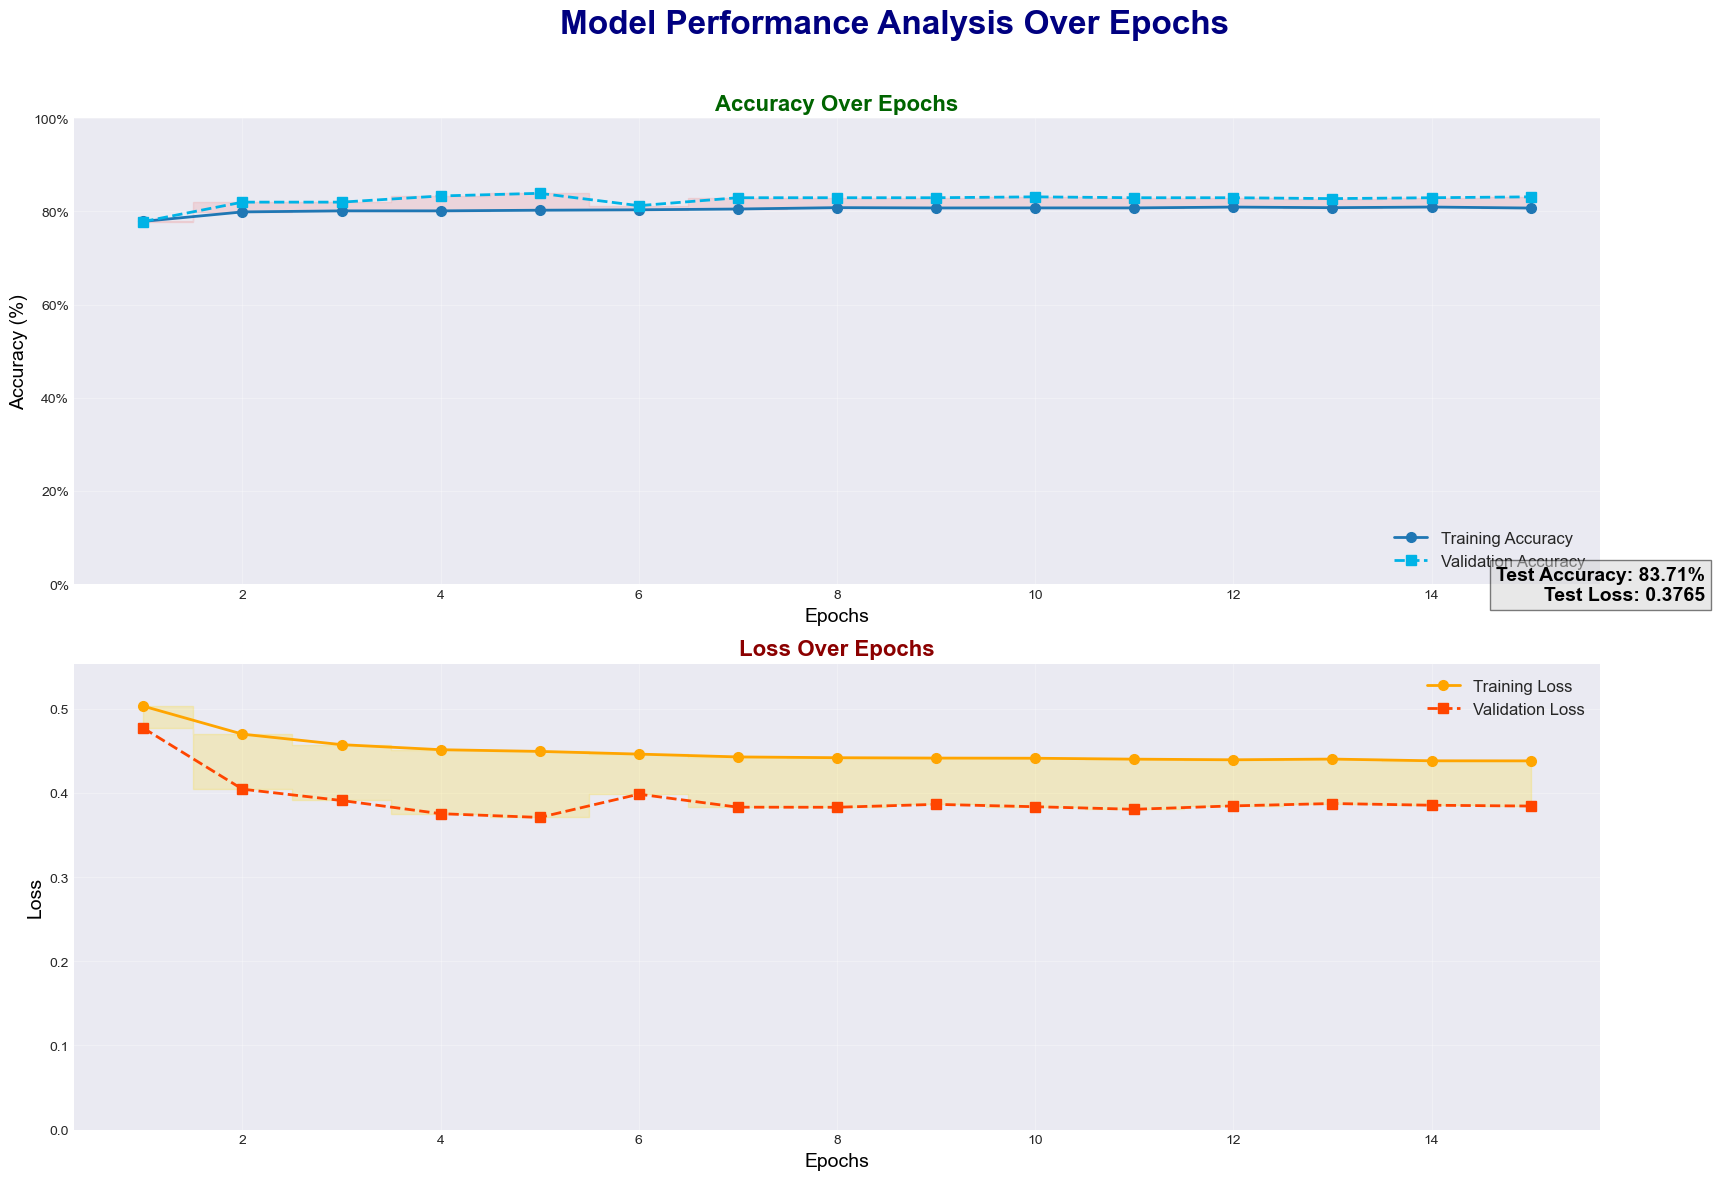

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


Combo model 4

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, PReLU, ELU
from tensorflow.keras.optimizers import Adam

def create_combo_5_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation=PReLU(), padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation=PReLU(), padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation=ELU(), padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation=ELU(), padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
combo_5_model = create_combo_5_model()
combo_5_model.summary()

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_381 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_381 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_219 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_382 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_382 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_383 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
combo_5_model = create_combo_5_model()
history = combo_5_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 153s 240ms/step - loss: 0.4917 - accuracy: 0.7860 - val_loss: 0.3644 - val_accuracy: 0.8523
Epoch 2/40
633/633 [==============================] - 132s 208ms/step - loss: 0.4708 - accuracy: 0.7980 - val_loss: 0.3999 - val_accuracy: 0.8277
Epoch 3/40
633/633 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.7987
Epoch 3: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 132s 209ms/step - loss: 0.4630 - accuracy: 0.7987 - val_loss: 0.3971 - val_accuracy: 0.8371
Epoch 4/40
633/633 [==============================] - 131s 207ms/step - loss: 0.4535 - accuracy: 0.8038 - val_loss: 0.3833 - val_accuracy: 0.8485
Epoch 5/40
633/633 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.8091
Epoch 5: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 131s 207ms/step - loss: 0.4457 - accuracy: 

In [ ]:

# Save the model
combo_5_model.save('combo_5_model.h5')
print("Model saved as combo_5_model.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = combo_5_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as combo_5_model.h5
Evaluating the model on the test data
33/33 [==============================] - 2s 47ms/step - loss: 0.3644 - accuracy: 0.8523
Test Loss: 0.3644
Test Accuracy: 0.8523


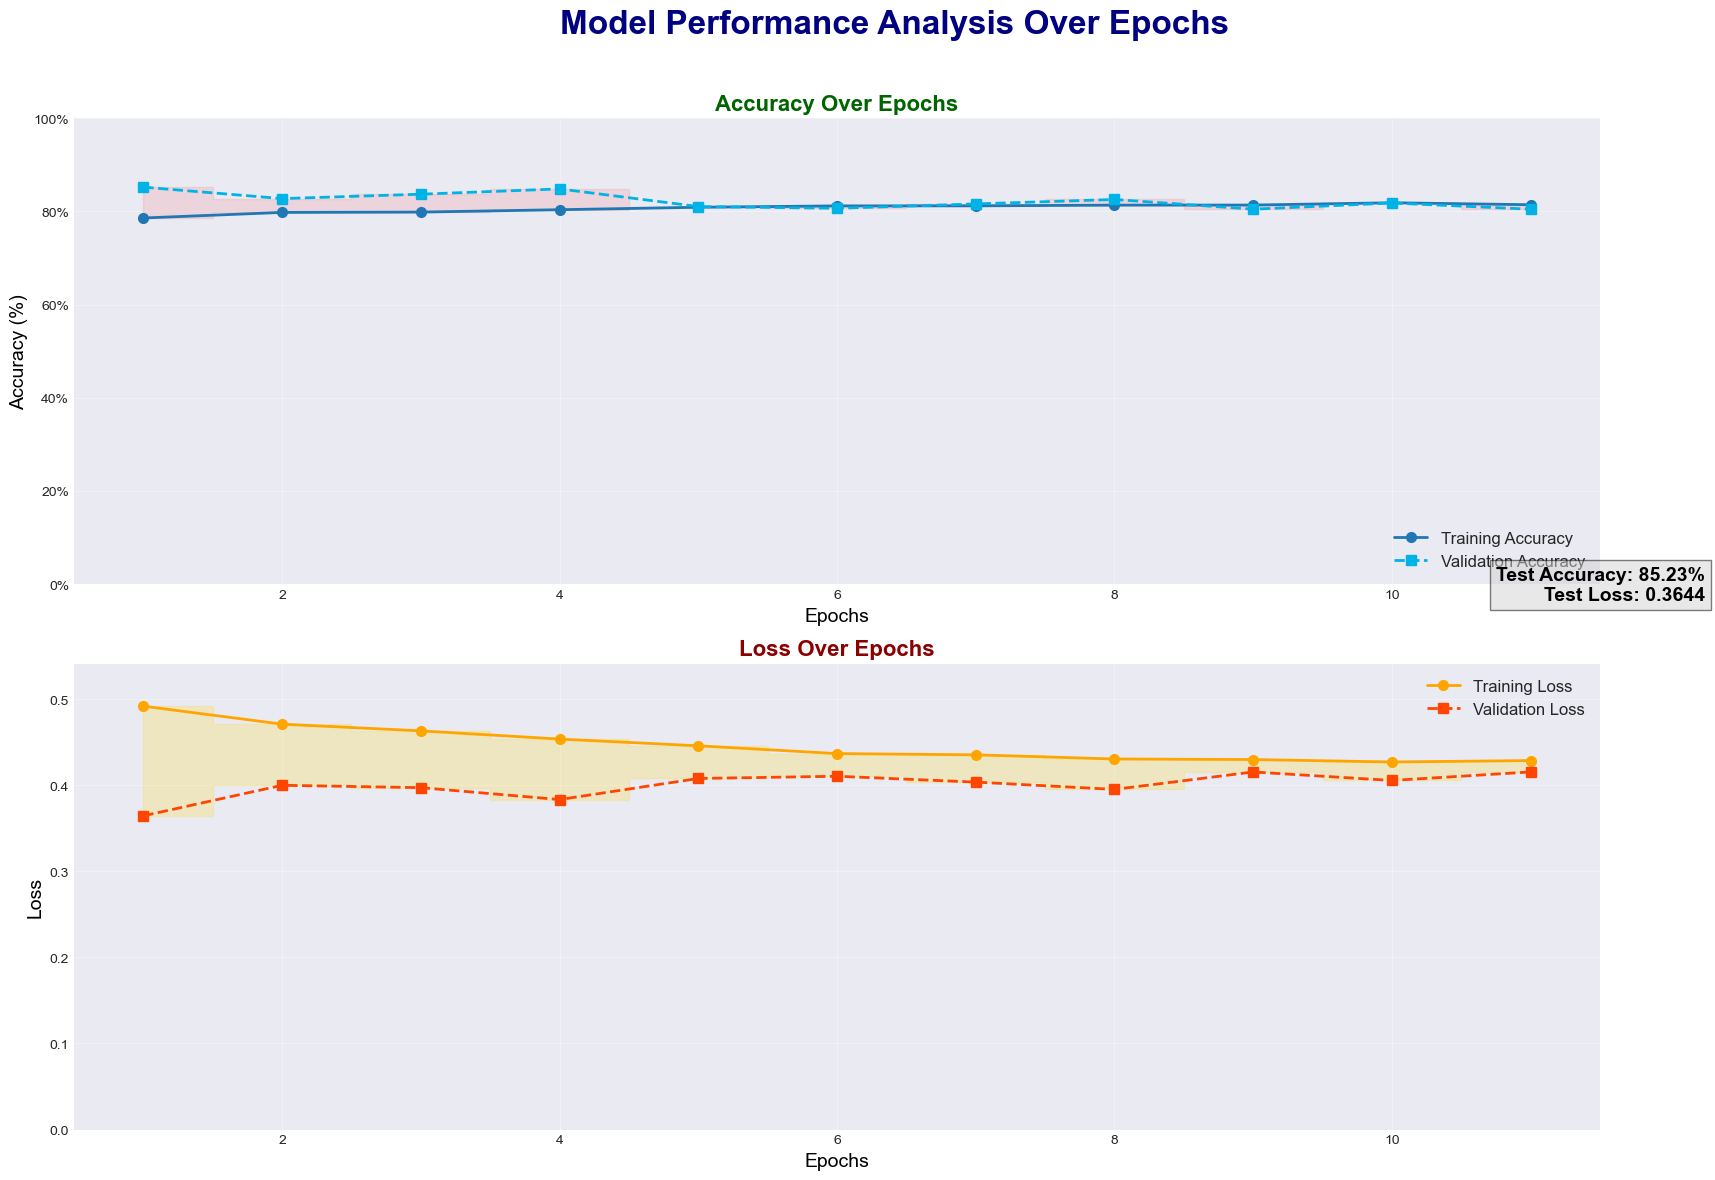

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


combo model 5

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AlphaDropout,
    Flatten,
    Dense,
    GlobalAveragePooling2D,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import lecun_normal

def create_selu_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1), kernel_initializer='lecun_normal'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        AlphaDropout(0.1),

        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='lecun_normal'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        AlphaDropout(0.1),

        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='lecun_normal'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        AlphaDropout(0.1),

        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='lecun_normal'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        AlphaDropout(0.1),

        GlobalAveragePooling2D(),

        Dense(64, activation='selu', kernel_initializer='lecun_normal'),
        AlphaDropout(0.2),

        Dense(1, activation='sigmoid')  # Keep sigmoid for binary classification output
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
model_selu = create_selu_model()
model_selu.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_443 (Conv2D)         (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_443 (MaxPooli  (None, 64, 64, 32)       0         
 ng2D)                                                           
                                                                 
 alpha_dropout_18 (AlphaDrop  (None, 64, 64, 32)       0         
 out)                                                            
                                                                 
 conv2d_444 (Conv2D)         (None, 64, 64, 64)        18496     
                                                     

In [ ]:

# Train the model
print("Training with combined dataset")
model_selu = create_selu_model()
history = model_selu.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 256s 400ms/step - loss: 0.5011 - accuracy: 0.7742 - val_loss: 11.5533 - val_accuracy: 0.6837
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.8020
Epoch 2: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 237s 374ms/step - loss: 0.4606 - accuracy: 0.8020 - val_loss: 32.8597 - val_accuracy: 0.6799
Epoch 3/40
633/633 [==============================] - 239s 377ms/step - loss: 0.4350 - accuracy: 0.8112 - val_loss: 31.4021 - val_accuracy: 0.6818
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.4253 - accuracy: 0.8178
Epoch 4: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 242s 383ms/step - loss: 0.4253 - accuracy: 0.8178 - val_loss: 25.0042 - val_accuracy: 0.6818
Epoch 5/40
633/633 [==============================] - 228s 360ms/step - loss: 0.4170 - accura

In [ ]:

# Save the model
model_selu.save('model_selu.h5')
print("Model saved as model_selu.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = model_selu.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as model_selu.h5
Evaluating the model on the test data
33/33 [==============================] - 3s 83ms/step - loss: 11.6187 - accuracy: 0.6818
Test Loss: 11.6187
Test Accuracy: 0.6818


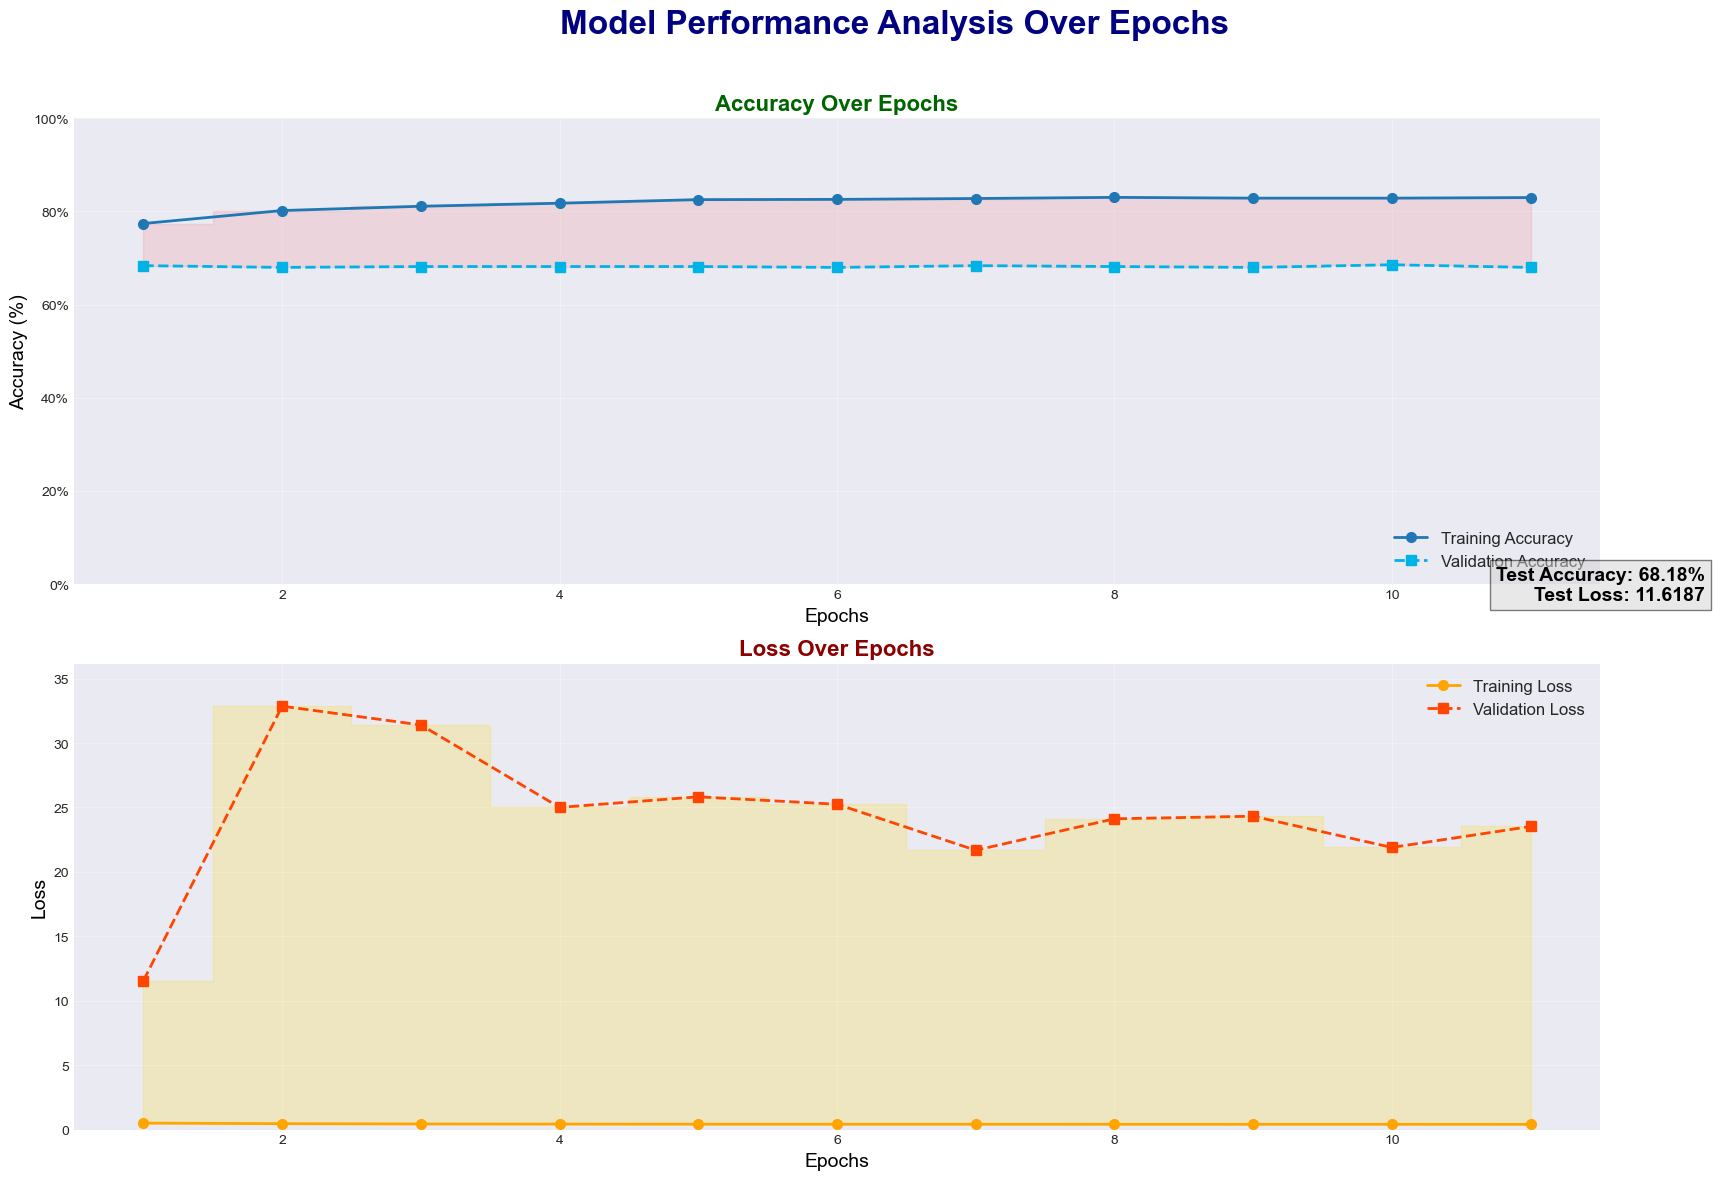

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                         arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                         fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
         ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


SELU activation function used in the above model along with alphadropout

In [ ]:
def create_thresholded_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation=ThresholdedReLU(theta=0.7), padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation=ThresholdedReLU(theta=0.7), padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_threshold = create_thresholded_model()
model_threshold.summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_403 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_403 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_225 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_404 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_404 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_405 (Conv2D)         (None, 32, 32, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
model_threshold = create_thresholded_model()
history = model_threshold.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.6819
Epoch 1: Reducing learning rate to 0.00035000001662410796.
633/633 [==============================] - 148s 231ms/step - loss: 0.6614 - accuracy: 0.6819 - val_loss: 0.6401 - val_accuracy: 0.6818
Epoch 2/40
633/633 [==============================] - 135s 213ms/step - loss: 0.6362 - accuracy: 0.6821 - val_loss: 0.6340 - val_accuracy: 0.6799
Epoch 3/40
633/633 [==============================] - ETA: 0s - loss: 0.6308 - accuracy: 0.6822
Epoch 3: Reducing learning rate to 0.00012250000581843777.
633/633 [==============================] - 137s 217ms/step - loss: 0.6308 - accuracy: 0.6822 - val_loss: 0.6293 - val_accuracy: 0.6818
Epoch 4/40
633/633 [==============================] - 135s 214ms/step - loss: 0.6288 - accuracy: 0.6819 - val_loss: 0.6284 - val_accuracy: 0.6818
Epoch 5/40
633/633 [==============================] - ETA: 0s - loss: 0.6278 - accuracy: 0.6822
E

KeyboardInterrupt: 

In [ ]:

# Save the model
model_threshold.save('model_threshold.h5')
print("Model saved as model_threshold.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = model_threshold.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                        arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                        fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                        arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                        fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
        ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dropout,
    Flatten,
    Dense,
    Activation,
    BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal, LecunNormal
from tensorflow.keras.callbacks import ReduceLROnPlateau

def create_combo_6_model():
        model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 1), kernel_initializer='he_normal'),
        Activation('relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
        Activation('relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
        Activation('relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'),
        Activation('relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        # Global Average Pooling for Parameter Efficiency
        GlobalAveragePooling2D(),

        # Fully Connected Layer with Softplus Activation
        Dense(128, kernel_initializer='lecun_normal'),
        Activation('softplus'),
        BatchNormalization(),
        Dropout(0.3),

        # Fully Connected Layer with Softplus Activation
        Dense(64, kernel_initializer='lecun_normal'),
        Activation('softplus'),
        BatchNormalization(),
        Dropout(0.3),

        # Output Layer with Sigmoid Activation for Binary Classification
        Dense(1, activation='sigmoid')
    ])
    
        model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
        return model

In [ ]:
combo_6_model = create_combo_6_model()
combo_6_model.summary()

Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_459 (Conv2D)         (None, 128, 128, 32)      320       
                                                                 
 activation_12 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_20 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_459 (MaxPooli  (None, 64, 64, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_249 (Dropout)       (None, 64, 64, 32)        0         
                                                                 
 conv2d_460 (Conv2D)         (None, 64, 64, 64)      

In [ ]:

# Train the model
print("Training with combined dataset")
combo_6_model = create_combo_6_model()
history = combo_4_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Training with combined dataset
Epoch 1/40
633/633 [==============================] - 206s 326ms/step - loss: 0.4444 - accuracy: 0.8042 - val_loss: 0.3792 - val_accuracy: 0.8352
Epoch 2/40
633/633 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.8065
Epoch 2: Reducing learning rate to 1e-07.
633/633 [==============================] - 197s 312ms/step - loss: 0.4457 - accuracy: 0.8065 - val_loss: 0.3781 - val_accuracy: 0.8352
Epoch 3/40
633/633 [==============================] - 176s 277ms/step - loss: 0.4461 - accuracy: 0.8044 - val_loss: 0.3762 - val_accuracy: 0.8371
Epoch 4/40
633/633 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.8047
Epoch 4: Reducing learning rate to 1e-07.
633/633 [==============================] - 236s 373ms/step - loss: 0.4456 - accuracy: 0.8047 - val_loss: 0.3791 - val_accuracy: 0.8352
Epoch 5/40
633/633 [==============================] - 265s 418ms/step - loss: 0.4456 - accuracy: 0.8066 - val_loss: 0.3774 - val_ac

In [ ]:

# Save the model
combo_6_model.save('combo_model_6.h5')
print("Model saved as combo_model_6.h5")

# Evaluating the model on the test data
print("Evaluating the model on the test data")
test_loss, test_accuracy = combo_6_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model saved as combo_model_6.h5
Evaluating the model on the test data
33/33 [==============================] - 8s 238ms/step - loss: 1.0007 - accuracy: 0.3201
Test Loss: 1.0007
Test Accuracy: 0.3201


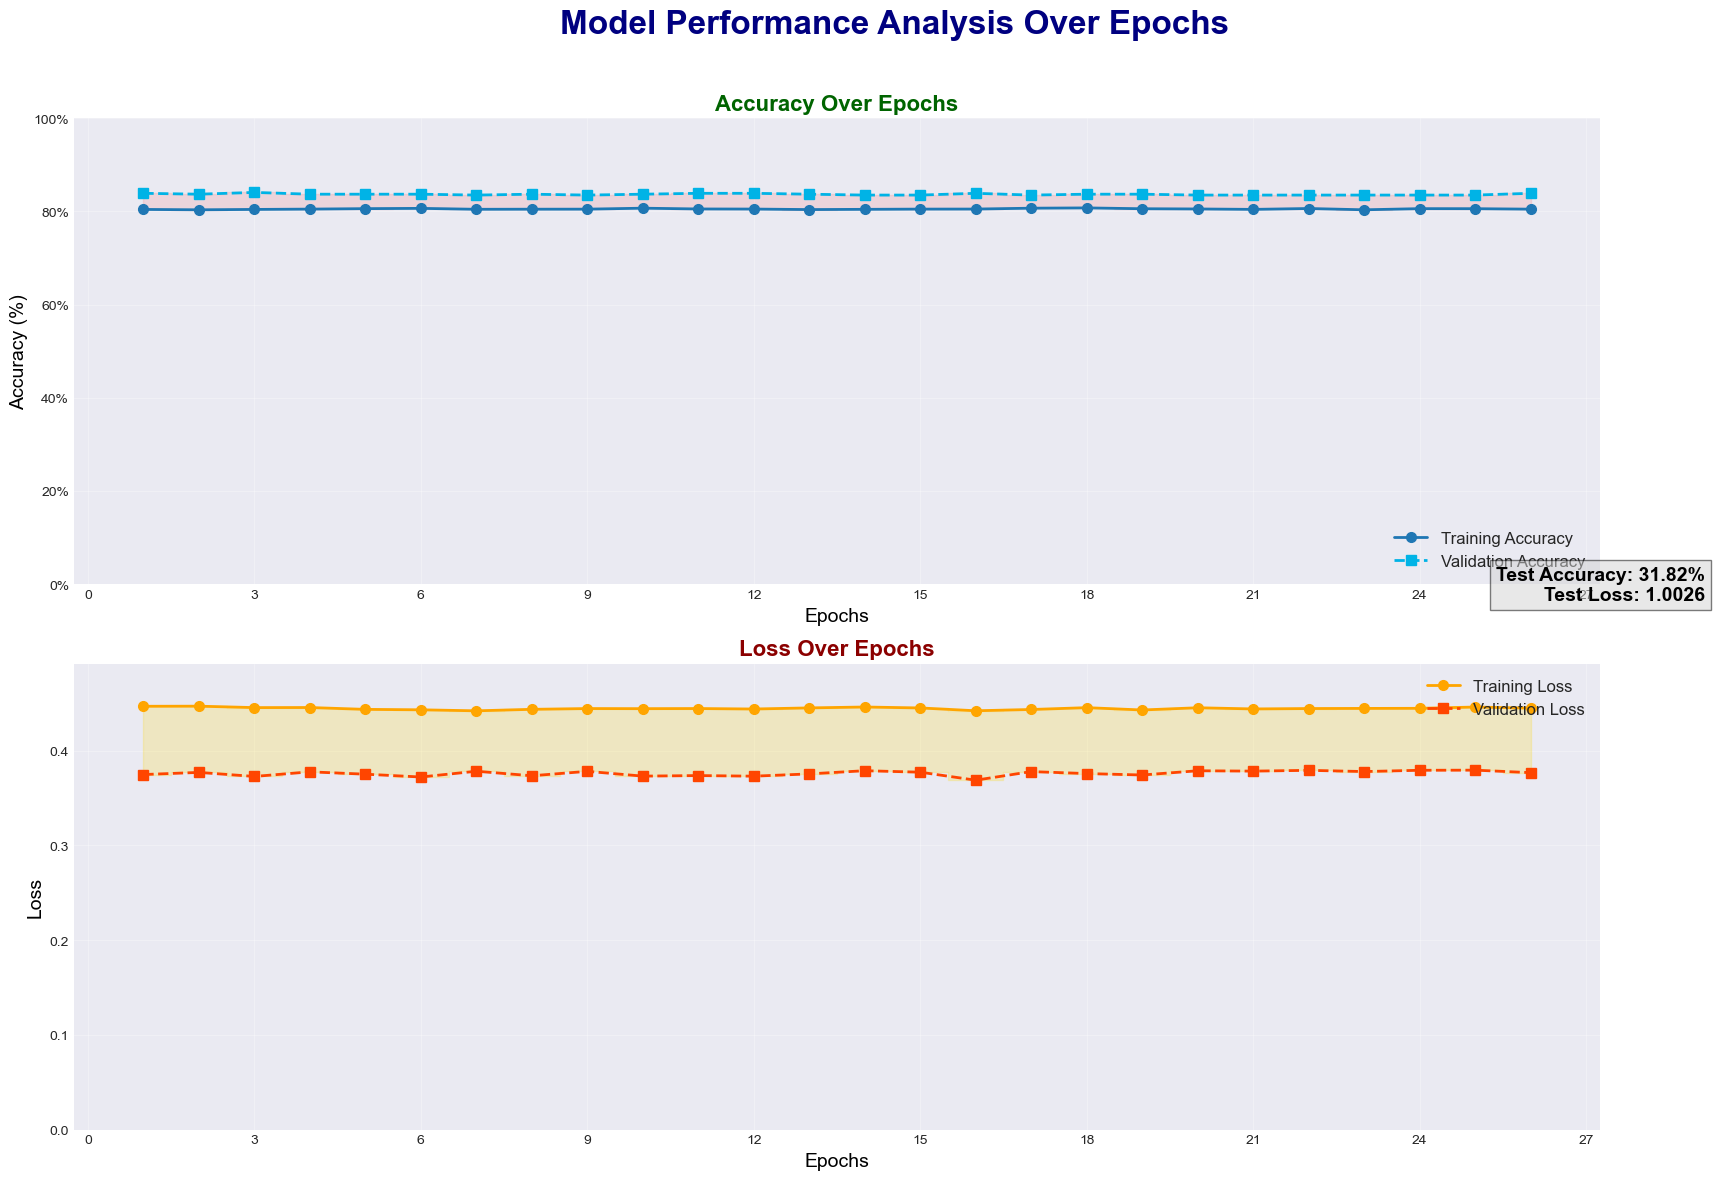

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Extracting data from history
epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, epochs+1)
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Custom color scheme
colors = {
    'train_acc': '#1f77b4',  # Deep blue
    'val_acc': '#00b3e6',    # Sky blue
    'train_loss': '#ffa500', # Orange
    'val_loss': '#ff4500',   # Red orange
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
fig.suptitle('Model Performance Analysis Over Epochs', fontsize=24, fontweight='bold', color='navy')

### Plot 1: Accuracy Over Epochs ###
axes[0].plot(epoch_range, train_accuracy, label='Training Accuracy', color=colors['train_acc'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[0].plot(epoch_range, val_accuracy, label='Validation Accuracy', color=colors['val_acc'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[0].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', color='darkgreen')
axes[0].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=14, fontweight='medium', color='black')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_ylim([0, 1.0])
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].legend(loc='lower right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[0].fill_between(epoch_range, train_accuracy, val_accuracy, color='lightcoral', alpha=0.2, step='mid')

# Highlight points of high validation accuracy
for i in range(len(val_accuracy)):
    if val_accuracy[i] > 0.9:  # For example, any accuracy > 90%
        axes[0].annotate(f'{val_accuracy[i]:.2%}', xy=(i+1, val_accuracy[i]), xytext=(i+1, val_accuracy[i]+0.05),
                        arrowprops=dict(facecolor='red', shrink=0.05, headwidth=6, headlength=8),
                        fontsize=10, color='red', fontweight='bold')

### Plot 2: Loss Over Epochs ###
axes[1].plot(epoch_range, train_loss, label='Training Loss', color=colors['train_loss'], linestyle='-', marker='o', markersize=7, linewidth=2)
axes[1].plot(epoch_range, val_loss, label='Validation Loss', color=colors['val_loss'], linestyle='--', marker='s', markersize=7, linewidth=2)
axes[1].set_title('Loss Over Epochs', fontsize=16, fontweight='bold', color='darkred')
axes[1].set_xlabel('Epochs', fontsize=14, fontweight='medium', color='black')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='medium', color='black')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_ylim([0, np.max([np.max(train_loss), np.max(val_loss)]) * 1.1]) # Adjust ylim based on max loss
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].legend(loc='upper right', fontsize=12, facecolor='lightgray', edgecolor='black')
axes[1].fill_between(epoch_range, train_loss, val_loss, color='gold', alpha=0.2, step='mid')

# Highlight points of high training loss
for i in range(len(train_loss)):
    if train_loss[i] > 0.6:  # Example threshold for high loss
        axes[1].annotate(f'{train_loss[i]:.4f}', xy=(i+1, train_loss[i]), xytext=(i+1, train_loss[i]+0.05),
                        arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=6, headlength=8),
                        fontsize=10, color='orange', fontweight='bold')

### Summary Annotations ###
# Display final test accuracy
summary_text = f'Test Accuracy: {test_accuracy:.2%}\nTest Loss: {test_loss:.4f}'
fig.text(0.95, 0.5, summary_text, fontsize=14, color='black', fontweight='bold',
        ha='right', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to accommodate the summary box
plt.show()
